In [82]:
## This file contains the basic function of read data and clean filter.
## Author: Xiang Li

###Sample
#### Imput Package
from pandas import pandas as pd
import numpy
import os
from scipy import stats
from optparse import OptionParser
from matplotlib import pyplot as plt

plt.switch_backend('agg')

# display plots in this notebook
%matplotlib inline

In [2]:
import HTSeq


In [136]:
def Distribute_By_Pileup(input_tag_file):
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(input_tag_file) ## input tags
    num_reads=0
    for alngt in bedfile:  # Total contribution of a single tag is ONE 
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1
    print "Number of Tags Being Distributed : %i" % num_reads
    return ga,num_reads

def Distribute_By_MiddlePoint(input_tag_file):
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(input_tag_file) ## input tags
    num_reads=0
    for alt in bedfile:
        alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start + alt.iv.end) / 2)
        ga[alt_pos]+=1
        num_reads+=1
    print "Number of Tags Being Distributed : %i" % num_reads
    return ga,num_reads

def Site_Position_Summit(input_site_file):
    ##########################################################################################    
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.

    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    for site in site_file:
        site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, (site.iv.start_d + site.iv.end_d)/2,site.iv.strand))
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    return site_pos_set

def Site_Position_Boundary(input_site_file, boundary_type):
    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    if (boundary_type=='TSS'):
        for site in site_file:
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.start_d, site.iv.strand))
    elif(boundary_type=='TES'):
        for site in site_file:
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.end_d, site.iv.strand))
    else:
        for site in site_file:
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.start, site.iv.strand))
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.end, site.iv.strand))
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    return site_pos_set

def Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension):
    ## ga is tags distribution, site_pos_set the sites for profile
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
##########################################################################################  
    profile = numpy.zeros(total_num_points)
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2)
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)
                else:
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    if (index_pos - window_size / 2) < 0:
                        index += 1
                        continue
                    else:
                        tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2)
                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    return profile

def Site_Position_Region(input_site_file, num_region_partition):
    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    Num_Skip = 0
    for site in site_file:
        if (site.iv.length < num_region_partition):
            Num_Skip+=1
            continue
        else:
            site_pos_set.add(site.iv)
    print "Number of Profiles Being Dropped (Length Less than Number of Partitions) : %i" % Num_Skip
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    return site_pos_set

def Get_Profile_In_Region(ga, site_pos_set, num_region_partition):
    # These methods yield iterators of :class:GenomicPosition objects from start to end (or, for xrange_d from start_d to end_d).
    profile = numpy.zeros(num_region_partition)  ### | | | | | |   5 partitions but only four sites for profile.
    ##########################################################################################
    ##########################################################################################
    for site_iv in site_pos_set:
        index = 0
        #i=0
        partition_size = site_iv.length / (1.0*genic_partition) ## Prevent int division
        for site_pos in site_iv.xrange_d(partition_size):
            #if (i==0):
            #    i+=1
            #    continue
            count_in_window = 0
            if site_pos.strand=="+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos, site_pos.pos + partition_size) 
            elif site_pos.strand=="-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size +1, site_pos.pos + 1) 
            elif site_pos.strand==".":
                print 'No strand'
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size, site_pos.pos + partition_size) 
            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile[index] += count_in_window / (1.0*partition_size)
            index += 1
            if index >= genic_partition:
                break
    return profile

In [148]:
def Get_Summit_Profile(input_tag_file, input_site_file, resolution, window_size, upstreamExtension, downstreamExtension):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Summit(input_site_file)
##########################################################################################
    profile = Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension)
    print "Profile on Sites Summit "
    print "...................................................."
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

def Get_Boundary_Profile(boundary_type, input_tag_file, input_site_file, resolution, window_size, upstreamExtension,downstreamExtension):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Boundary(input_site_file, boundary_type)
##########################################################################################
    profile = Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension)
    print "Profile on Site Boundary "+ boundary_type
    print "...................................................."
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

def Get_Bed_Region_Profile(input_tag_file, input_site_file, num_region_partition):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Region(input_site_file, num_region_partition)
##########################################################################################
    profile = Get_Profile_In_Region(ga, site_pos_set, num_region_partition)
    print "Profile on Site Region"
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    print "...................................................."
    return (profile*(10**9)/(num_reads*len(site_pos_set)))

In [175]:
def Get_Profile_In_Region(ga, site_pos_set, num_region_partition):
    # These methods yield iterators of :class:GenomicPosition objects from start to end (or, for xrange_d from start_d to end_d).
    profile = numpy.zeros(num_region_partition)  ### | | | | | |   5 partitions but only four sites for profile.
    profile_inverse = numpy.zeros(num_region_partition)
    ##########################################################################################
    ##########################################################################################
    site_inverse_set=set()
    for site in site_pos_set:
        if (site.strand=='-'):
            site_inverse_set.add(HTSeq.GenomicInterval(site.chrom, site.start, site.end, '+'))
        else:
            site_inverse_set.add(HTSeq.GenomicInterval(site.chrom, site.start, site.end, '-'))
     
    for site_iv in site_pos_set:
        index = 0
        partition_size = site_iv.length / (1.0*genic_partition) ## Prevent int division        

        for site_pos in site_iv.xrange_d(partition_size):
            #if (i==0):
            #    i+=1
            #    continue
            count_in_window = 0
            if site_pos.strand=="+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos, site_pos.pos + partition_size) 
            elif site_pos.strand=="-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size +1, site_pos.pos + 1) 
            elif site_pos.strand==".":
                print 'No strand'
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size, site_pos.pos + partition_size) 
            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile[index] += count_in_window / (1.0*partition_size)
            index += 1
            if index >= genic_partition:
                break
    
    for site_iv in site_inverse_set:
        index = 0
        partition_size = site_iv.length / (1.0*genic_partition) ## Prevent int division        

        for site_pos in site_iv.xrange_d(partition_size):
            #if (i==0):
            #    i+=1
            #    continue
            count_in_window = 0
            if site_pos.strand=="+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos, site_pos.pos + partition_size) 
            elif site_pos.strand=="-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size +1, site_pos.pos + 1) 
            elif site_pos.strand==".":
                print 'No strand'
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size, site_pos.pos + partition_size) 
            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile_inverse[index] += count_in_window / (1.0*partition_size)
            index += 1
            if index >= genic_partition:
                break
    profile_inverse=profile_inverse[::-1]
    
    return numpy.concatenate((profile[0:num_region_partition/2], profile_inverse[num_region_partition/2:]), axis=0)

....................................................
Profile on: TSS_3'UTR_TES 


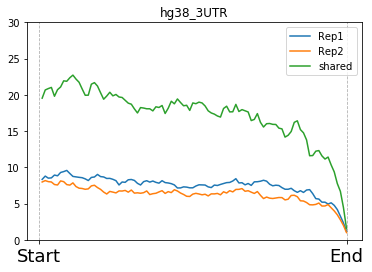

In [177]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name

genic_partition = 100
#norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
#norm_profile_2 = Get_Bed_Region_Profile(INPUT_read_file2, INPUT_gene_list, genic_partition)
#norm_profile_3 = Get_Bed_Region_Profile(INPUT_read_file3, INPUT_gene_list, genic_partition)

print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='Rep1')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='Rep2')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[0:genic_partition], label='shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_3'UTR_TES 


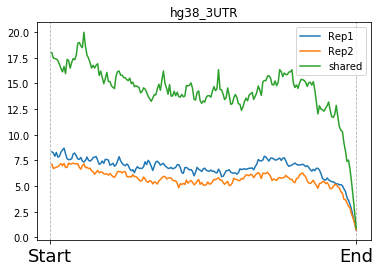

In [151]:
print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
#ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='Rep1')
#ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='Rep2')
#ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[0:genic_partition], label='shared')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[::-1], label='Rep1')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[::-1], label='Rep2')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[::-1], label='shared')

ax.set_title(Gene_Name[:-4])
ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 100035
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 2735
Number of Profiles Being Averaged : 15640
Profile on Site Region
....................................................
Number of Tags Being Distributed : 112488
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 2735
Number of Profiles Being Averaged : 15640
Profile on Site Region
....................................................
Number of Tags Being Distributed : 18368
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 2735
Number of Profiles Being Averaged : 15640
Profile on Site Region
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


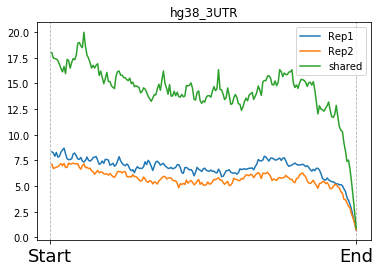

In [144]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name

genic_partition = 200
norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
norm_profile_2 = Get_Bed_Region_Profile(INPUT_read_file2, INPUT_gene_list, genic_partition)
norm_profile_3 = Get_Bed_Region_Profile(INPUT_read_file3, INPUT_gene_list, genic_partition)

print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='Rep1')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='Rep2')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[0:genic_partition], label='shared')

ax.set_title(Gene_Name[:-4])
ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_3'UTR_TES 


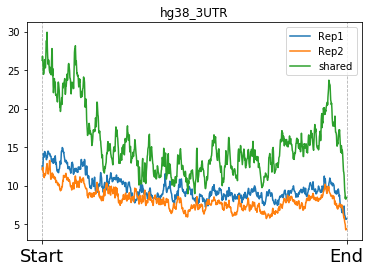

In [137]:
print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), 2*norm_profile[0:genic_partition], label='Rep1')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), 2*norm_profile_2[0:genic_partition], label='Rep2')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), 2*norm_profile_3[0:genic_partition], label='shared')

ax.set_title(Gene_Name[:-4])
ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

In [69]:
site_set, num = Site_Position_Region(INPUT_gene_list,20)

for site in site_set:
    index = 0
    print site
    partition_size = site.length / (1.0*genic_partition) ## Prevent int division
    print partition_size
    for site_pos in site.xrange_d(partition_size):
        print site_pos
        index+=1
        if (index == 3): break
    break

site_inverse_set=set()
for site in site_set:
    if (site.strand=='-'):
        site_inverse_set.add(HTSeq.GenomicInterval(site.chrom, site.start, site.end, '+'))
    else:
        site_inverse_set.add(HTSeq.GenomicInterval(site.chrom, site.start, site.end, '-'))
    break
    
for site in site_inverse_set:
    index = 0
    print site
    partition_size = site.length / (1.0*genic_partition) ## Prevent int division
    print partition_size
    for site_pos in site.xrange_d(partition_size):
        print site_pos
        index+=1
        if (index == 3): break
    break

Number of Profiles Being Dropped (Length Less than Number of Partitions) : 110
Number of Profiles Being Averaged : 18247
chr5:[40692379,40693736)/+
27.14
chr5:40692379/+
chr5:40692406/+
chr5:40692433/+
chr5:[40692379,40693736)/-
27.14
chr5:40693735/-
chr5:40693708/-
chr5:40693681/-


In [98]:
PATH_FOLDER=os.getcwd() 
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"

Name1="/hg38_3UTR.bed"
INPUT_gene_list = PATH_FOLDER + Name1

upstreamExtension =1000
resolution = upstreamExtension/100
window_size = resolution

num_profile_points= 2*upstreamExtension / resolution +1
norm_profile   = Get_Boundary_Profile('TSS',INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Boundary_Profile('TSS',INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile3   = Get_Boundary_Profile('TSS',INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)

Number of Tags Being Distributed : 100035
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 112488
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 18368
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................


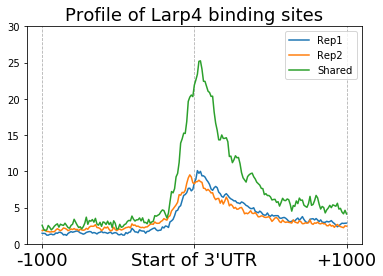

In [100]:
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='Rep1')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='Rep2')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3[0:num_profile_points], label='Shared')

#ax.set_title(Name1[:-4])
ax.set_title("Profile of Larp4 binding sites", size=18)

ax.legend()
ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Start of 3\'UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

In [ ]:
def Get_GeneBody_Profile(INPUT_read_file, INPUT_gtf_file, Feature_Type_Used, INPUT_gene_list, genic_partition, fragment_size):
    ## Read Reads_File, and distribute them into GenomicArray.
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    for alngt in bedfile:
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1
##########################################################################################
    ## Read gtf_file
    gtffile = HTSeq.GFF_Reader(INPUT_gtf_file)
##########################################################################################    
    ## Read Gene_list_file
    gene_list = pd.read_csv(INPUT_gene_list, header=None, sep='\s+', usecols=[3])[3].str.strip()
    gene_list_unique=gene_list.unique()
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_iv_set = set()
    
    gff_feature_type_for_profile = Feature_Type_Used

    for feature in gtffile:
        if feature.type == Feature_Type_Used and feature.attr["gene_id"] in gene_list_unique:
            site_iv_set.add(feature.iv)
    
    profile = numpy.zeros(genic_partition)
    Num_Skip = 0
    for site_iv in site_iv_set:
        partition_size =site_iv.length / (1.0*genic_partition) ## Prevent int division
        if(partition_size < 1):
            Num_Skip +=1 
            continue
##########################################################################################
        index = 0
        for site_pos in site_iv.xrange_d(partition_size):
            count_in_window = 0
            if site_pos.strand == "+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos, site_pos.pos + partition_size)
            elif site_pos.strand == "-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size + 1,
                                                           site_pos.pos + 1)

            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile[index] += count_in_window / (1.0*partition_size)
            index += 1
            if index >= genic_partition:
                break
    
    print "...................................................."
    print "Profile on: TSS_GeneBody_TES "
    print "Number of transcripts: %i" % len(site_iv_set)
    print "Number of reads: %i" % num_reads 
    print "...................................................."
    print ("Total Number of Skipped gene_list: "+str(Num_Skip))
    print ("Because their length are less than your choose genic_partition")
        
    return  (profile*(10**9)/(num_reads*(len(site_iv_set)-Num_Skip)))

In [ ]:
#Sunmit Profile
PATH_FOLDER=os.getcwd() + '/reads_removed_repeats/islandfiltered/'
PATH_FOLDER='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/Tcf1_Sep2016/Bowtie2_Results/naiveCD8/'
PATH_FOLDER='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/Bowtie2_Results/ctrl_CD8_K27Ac/'

INPUT_read_file = PATH_FOLDER + 'WT-na_islandfiltered.bedpe'
INPUT_read_file_2 = PATH_FOLDER + 'dKO-na_islandfiltered.bedpe'
INPUT_read_file_3 = PATH_FOLDER + 'WT-s_islandfiltered.bedpe'
INPUT_read_file_4 = PATH_FOLDER + 'dKO-s_islandfiltered.bedpe'

INPUT_read_file = PATH_FOLDER + 'ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed.bed'
INPUT_read_file_2 = PATH_FOLDER + 'dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed.bed'


PATH_FOLDER=os.getcwd() + '/MACS2_Results/bampe/Union_all/'

#Gene_Name='12532_TCF1+_TCF1_MOTIF_-_Union_peak_For_HTseq.bed'

#Gene_Name = '23403_Union_WT-na_dKO-na_removed_Satellite_Simple_repeat_chrM.bed'
INPUT_LIST=os.listdir(PATH_FOLDER)
#Gene_Name = '25284_Union_peaks_final_removal.bed'
Gene_Name = '1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed'
print INPUT_LIST

INPUT_gene_list = PATH_FOLDER + Gene_Name

INPUT_gene_list2 = PATH_FOLDER + Gene_Name2

resolution = 20
upstreamExtension = 2000
num_profile_points= 2*upstreamExtension / resolution +1

norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, 200, resolution, upstreamExtension, upstreamExtension)
norm_profile_2 = Get_Summit_Profile(INPUT_read_file_2, INPUT_gene_list, 200,  resolution, upstreamExtension, upstreamExtension)
#norm_profile_3 = Get_Summit_Profile(INPUT_read_file_3, INPUT_gene_list, 200, resolution, upstreamExtension, upstreamExtension)
#norm_profile_4 = Get_Summit_Profile(INPUT_read_file_4, INPUT_gene_list, 200, resolution, upstreamExtension, upstreamExtension)


['all_summits_extend_100.bed', 'ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed', '.ipynb_checkpoints', '13449_K27Ac_peaks.bed', '12532_TCF1+_TCF1_MOTIF_-_Union_peak_For_HTseq.bed', '6987_K27Ac_fitleredpeaks.bed', 'version.beta', '25284_Union_peaks_final_removal.bed', '1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed', '28459_Union_peaks.bed', '1297_Tcf1_Motif_+_Union_peaks.bed', '1297__distribution.txt', '12532__distribution.txt', 'Plot_PCA_Heatmap_Violin_venn_scattering_profile.ipynb', 'top_1000.bed']
....................................................
Profile on peak Summit 
Number of transcripts: 1297
Number of reads: 12841605


....................................................
Profile on: TSS_GeneBody_TES 
....................................................
Because their length are less than your choose genic_partition


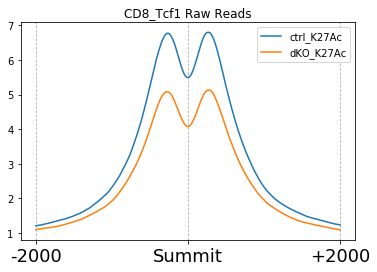

In [38]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
#print "Number of transcripts: %i" % len(ga_region_from_bedfile)
#print "Number of reads: %i" % num_reads 
print "...................................................."
#print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

#print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

#print  (norm_profile)

### Plot     
fig, ax=plt.subplots(1,1) #, figsize=(8, 6)
x_range=np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2)
ax.plot(x_range, norm_profile[0:num_profile_points], label='ctrl_K27Ac')
ax.plot(x_range, norm_profile_2[0:num_profile_points], label='dKO_K27Ac')
#ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_3[0:num_profile_points], label='WT_s')
#ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_4[0:num_profile_points], label='DKO_s')

ax.set_title('')
ax.legend()
ax.set_ylim(0.9,7)
x=[min(x_range),0,max(x_range)]
ax.set_xticks(x)
customized_xticks=['-2000','Summit','+2000']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

In [29]:
#Sunmit Profile
PATH_FOLDER=os.getcwd() + '/reads_removed_repeats/islandfiltered/'
PATH_FOLDER='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/Tcf1_Sep2016/Bowtie2_Results/naiveCD8/'
INPUT_read_file = PATH_FOLDER + 'WT-na_islandfiltered.bedpe'
INPUT_read_file_2 = PATH_FOLDER + 'dKO-na_islandfiltered.bedpe'
INPUT_read_file_3 = PATH_FOLDER + 'WT-s_islandfiltered.bedpe'
INPUT_read_file_4 = PATH_FOLDER + 'dKO-s_islandfiltered.bedpe'

INPUT_read_file_2 = PATH_FOLDER + 'naiveCD8_Dup_Simple_Repeats_Removed.bedpe'

PATH_FOLDER=os.getcwd() + '/MACS2_Results/bampe/Union_all/'

Gene_Name='12532_TCF1+_TCF1_MOTIF_-_Union_peak_For_HTseq.bed'
#Gene_Name = '23403_Union_WT-na_dKO-na_removed_Satellite_Simple_repeat_chrM.bed'
INPUT_LIST=os.listdir(PATH_FOLDER)
#Gene_Name = '25284_Union_peaks_final_removal.bed'
#Gene_Name = '1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed'
print INPUT_LIST


INPUT_gene_list = PATH_FOLDER + Gene_Name

resolution = 20
upstreamExtension = 2000
num_profile_points= 2*upstreamExtension / resolution +1

#norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, 200, resolution, upstreamExtension, upstreamExtension)
norm_profile_2 = Get_Summit_Profile(INPUT_read_file_2, INPUT_gene_list, 200,  resolution, upstreamExtension, upstreamExtension)
#norm_profile_3 = Get_Summit_Profile(INPUT_read_file_3, INPUT_gene_list, 200, resolution, upstreamExtension, upstreamExtension)
#norm_profile_4 = Get_Summit_Profile(INPUT_read_file_4, INPUT_gene_list, 200, resolution, upstreamExtension, upstreamExtension)


['all_summits_extend_100.bed', 'ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed', '.ipynb_checkpoints', '13449_K27Ac_peaks.bed', '12532_TCF1+_TCF1_MOTIF_-_Union_peak_For_HTseq.bed', '6987_K27Ac_fitleredpeaks.bed', 'version.beta', '25284_Union_peaks_final_removal.bed', '1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed', '28459_Union_peaks.bed', '1297_Tcf1_Motif_+_Union_peaks.bed', '1297__distribution.txt', '12532__distribution.txt', 'Plot_PCA_Heatmap_Violin_venn_scattering_profile.ipynb', 'top_1000.bed']
....................................................
Profile on peak Summit 
Number of transcripts: 12532
Number of reads: 32154844


....................................................
Profile on: TSS_GeneBody_TES 
....................................................
Because their length are less than your choose genic_partition
[  1.55674513   1.57104955   1.59062825   1.60057092   1.59936412
   1.59613728   1.59535702   1.59975981   1.61260646   1.63098516
   1.64999756   1.67139018   1.70303412   1.75598863   1.82223366
   1.89293366   1.94853477   1.98948975   2.02756172   2.07779485
   2.15143355   2.24695904   2.34598494   2.41598491   2.44818738
   2.45119996   2.45987228   2.48933701   2.53240936   2.57103547
   2.58624762   2.57165898   2.53975274   2.52449177   2.5358321
   2.56538402   2.5894144    2.59629426   2.59133404   2.58722154
   2.59859261   2.62687296   2.66344563   2.69109688   2.71128023
   2.73534883   2.78028079   2.85053557   2.94381223   3.04726891
   3.13683364   3.20811561   3.26171581   3.31240654   3.36154677
   3.40960403   3.45781422   3.51185013   3.5713956    3.63903704
   3.72799

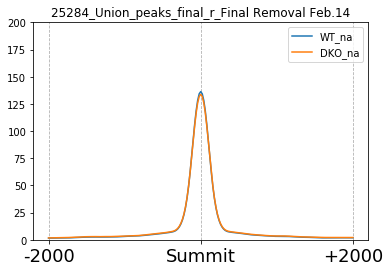

In [27]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
#print "Number of transcripts: %i" % len(ga_region_from_bedfile)
#print "Number of reads: %i" % num_reads 
print "...................................................."
#print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

#print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile)

### Plot     
fig, ax=plt.subplots(1,1) #, figsize=(8, 6)
x_range=np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2)
ax.plot(x_range, norm_profile[0:num_profile_points], label='WT_na')
ax.plot(x_range, norm_profile_2[0:num_profile_points], label='DKO_na')
#ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_3[0:num_profile_points], label='WT_s')
#ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_4[0:num_profile_points], label='DKO_s')

ax.set_title(Gene_Name[:-10]+'_Final Removal Feb.14')
ax.legend()
ax.set_ylim(0,200)
x=[min(x_range),0,max(x_range)]
ax.set_xticks(x)
customized_xticks=['-2000','Summit','+2000']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_GeneBody_TES 
....................................................
Because their length are less than your choose genic_partition
[  1.24138873   1.24695549   1.27478932   1.27107814   1.28592285
   1.30818991   1.26551138   1.25994461   1.28035609   1.29148962
   1.32860139   1.35272404   1.32303462   1.31375668   1.29334521
   1.29705638   1.32303462   1.34159051   1.3434461    1.30076756
   1.29148962   1.31932344   1.31375668   1.34901286   1.41766964
   1.41766964   1.4232364    1.46591494   1.53828289   1.75167557
   1.96321266   1.9891909    2.06898121   2.13392681   2.20443917
   2.35474184   2.41783185   2.47164392   2.44566568   2.36773096
   2.28608507   2.31577448   2.38072008   2.43824333   2.47906628
   2.47721069   2.54215629   2.51988922   2.55700099   2.5718457
   2.62936895   2.63493571   2.69988131   2.64606924   2.57370129
   2.56442335   2.51988922   2.55328982   2.58297923   2.62751336
   2.69802

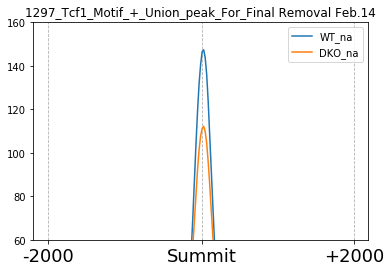

In [45]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
#print "Number of transcripts: %i" % len(ga_region_from_bedfile)
#print "Number of reads: %i" % num_reads 
print "...................................................."
#print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

#print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile)

### Plot     
fig, ax=plt.subplots(1,1) #, figsize=(8, 6)
ax.plot(np.arange(-(num_profile_points)/2,(num_profile_points)/2), norm_profile[0:num_profile_points], label='WT_na')
#ax.plot(np.arange(-(num_profile_points)/2,(num_profile_points)/2), norm_profile_2[0:num_profile_points], label='DKO_na')
#ax.plot(np.arange(-(num_profile_points)/2,(num_profile_points)/2), norm_profile_3[0:num_profile_points], label='WT_s')
#ax.plot(np.arange(-(num_profile_points)/2,(num_profile_points)/2), norm_profile_4[0:num_profile_points], label='DKO_s')

ax.set_title(Gene_Name[:-10]+'_Final Removal Feb.14')
ax.legend()
ax.set_ylim(60,160)
x=[-(num_profile_points)/2,0,(num_profile_points)/2]
ax.set_xticks(x)
customized_xticks=['-2000','Summit','+2000']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_GeneBody_TES 
....................................................
Because their length are less than your choose genic_partition
[ 70.12406933  89.99357388 110.18286813 128.64767648 142.84777067
 154.68357336 164.76545278 172.62801988 179.76174499 186.47013794
 188.078308   184.30662724 177.15873983 168.53044457 158.48685553
 146.61101982 131.01941425 111.93473042  89.04524161  64.4745343 ]


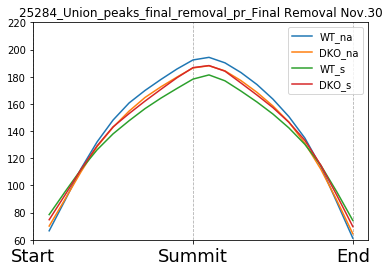

In [19]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
#print "Number of transcripts: %i" % len(ga_region_from_bedfile)
#print "Number of reads: %i" % num_reads 
print "...................................................."
#print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

#print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile_2)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[0:genic_partition], label='WT_s')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_4[0:genic_partition], label='DKO_s')

ax.set_title(Gene_Name[:-10]+'_Final Removal Nov.30')
ax.legend()
ax.set_ylim(60,220)
x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Summit','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_GeneBody_TES 
Number of transcripts: 26211
Number of reads: 1588966
....................................................
Total Number of Skipped gene_list: 0
Because their length are less than your choose genic_partition
[ 67.35596775  85.80980327 104.11456217 120.90653045 134.65737648
 144.97863691 153.19671176 160.2184578  167.11841052 175.02487058
 177.37637145 172.45673898 165.26798177 157.48591373 148.50619817
 138.15383135 124.61895638 106.88745721  84.88965696  61.60295964]
[ 67.35596775  85.80980327 104.11456217 120.90653045 134.65737648
 144.97863691 153.19671176 160.2184578  167.11841052 175.02487058
 177.37637145 172.45673898 165.26798177 157.48591373 148.50619817
 138.15383135 124.61895638 106.88745721  84.88965696  61.60295964]


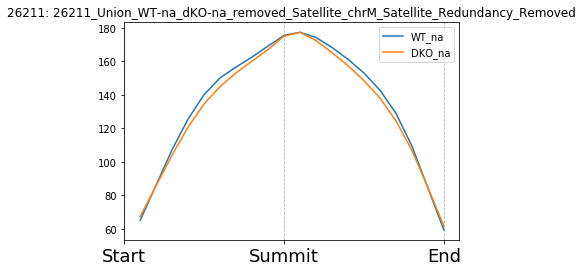

In [75]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
print "Number of transcripts: %i" % len(ga_region_from_bedfile)
print "Number of reads: %i" % num_reads 
print "...................................................."
print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile_2)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na')
ax.set_title(str(len(ga_region_from_bedfile))+': '+Gene_Name[:-4]+'_Satellite_Redundancy_Removed')
ax.legend()

x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Summit','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_GeneBody_TES 
Number of transcripts: 26292
Number of reads: 2973030
....................................................
Total Number of Skipped gene_list: 0
Because their length are less than your choose genic_partition
[ 42.99567347  55.90428952  67.33859382  77.04169536  85.65856158
  93.18665269  99.70671921 106.05044243 112.46861351 117.01887136
 116.20317714 111.98664038 107.78603568 103.70411666  97.01693319
  89.60497482  80.59471461  69.35934639  54.72228944  37.18423146]
[ 42.99567347  55.90428952  67.33859382  77.04169536  85.65856158
  93.18665269  99.70671921 106.05044243 112.46861351 117.01887136
 116.20317714 111.98664038 107.78603568 103.70411666  97.01693319
  89.60497482  80.59471461  69.35934639  54.72228944  37.18423146]


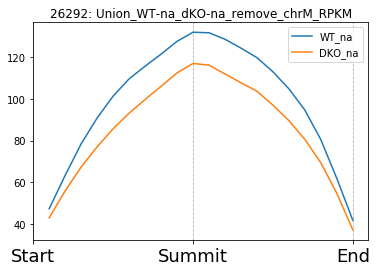

In [30]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
print "Number of transcripts: %i" % len(ga_region_from_bedfile)
print "Number of reads: %i" % num_reads 
print "...................................................."
print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile_2)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na')
ax.set_title(str(len(ga_region_from_bedfile))+': '+Gene_Name[:-4])
ax.legend()

x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Summit','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_GeneBody_TES 
Number of transcripts: 26292
Number of reads: 10915817
....................................................
Total Number of Skipped gene_list: 0
Because their length are less than your choose genic_partition
[23.13272728 29.68594855 33.2569656  37.31954419 44.15497148 57.76859053
 71.92271521 80.0365764  81.76740855 78.77526954 71.35889403 66.71736225
 75.85874051 76.88581272 62.90729456 93.0808301  90.31747314 46.07432353
 31.19261427 16.24718807]
[23.13272728 29.68594855 33.2569656  37.31954419 44.15497148 57.76859053
 71.92271521 80.0365764  81.76740855 78.77526954 71.35889403 66.71736225
 75.85874051 76.88581272 62.90729456 93.0808301  90.31747314 46.07432353
 31.19261427 16.24718807]


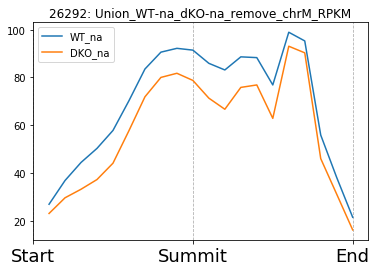

In [26]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
print "Number of transcripts: %i" % len(ga_region_from_bedfile)
print "Number of reads: %i" % num_reads 
print "...................................................."
print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile_2)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na')
ax.set_title(str(len(ga_region_from_bedfile))+': '+Gene_Name[:-4])
ax.legend()

x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Summit','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: TSS_GeneBody_TES 
Number of transcripts: 26310
Number of reads: 10915817
....................................................
Total Number of Skipped gene_list: 0
Because their length are less than your choose genic_partition
[24.21417223 30.93929254 34.62476762 38.68602668 45.47118527 59.00434615
 73.22984137 81.49083941 83.27796943 80.36734946 73.03703338 68.41606806
 77.60236335 78.41096601 64.13976656 94.25116961 91.57593289 47.49645047
 32.61962875 17.27984512]
[24.21417223 30.93929254 34.62476762 38.68602668 45.47118527 59.00434615
 73.22984137 81.49083941 83.27796943 80.36734946 73.03703338 68.41606806
 77.60236335 78.41096601 64.13976656 94.25116961 91.57593289 47.49645047
 32.61962875 17.27984512]


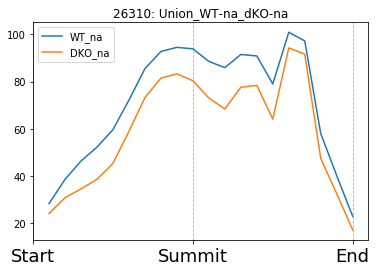

In [19]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
print "Number of transcripts: %i" % len(ga_region_from_bedfile)
print "Number of reads: %i" % num_reads 
print "...................................................."
print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")

print  (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

print  (norm_profile_2)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na')
ax.set_title(str(len(ga_region_from_bedfile))+': '+Gene_Name[:-4])
ax.legend()

x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Summit','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

In [ ]:
## Exactly Coordinates
####
num_reads = 0
resolution = 100
upstreamExtension = 1000
downstreamExtension = 1000
### Set up number of points
upstream_num_points = upstreamExtension / resolution
downstream_num_points = downstreamExtension / resolution
total_num_points = upstream_num_points + downstream_num_points + 1
profile = numpy.zeros(total_num_points)


ga = HTSeq.GenomicArray("auto", stranded=False, typecode="i")
### WT-na
bedfile = HTSeq.BED_Reader(INPUT_read_file)
### WT-na
for alt in bedfile:
    if alt.iv.strand == "+":
        alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d + fragment_size / 2)
    elif alt.iv.strand == "-":
        alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d - fragment_size / 2)
    elif (alt.iv.strand =="." ):
        alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start+alt.iv.end)/2 )
    ga[alt_pos] += 1
    num_reads += 1
### After above for loop, we have location information of all input reads summit. 

##########################################################################################
### To calculate the number of transcripts that for profile plot.
### And also store position in a set.
region_bedfile = HTSeq.BED_Reader(INPUT_gene_list)
ga_region_from_bedfile=set()### Only ga has feature 
# These methods yield iterators of :class:GenomicPosition objects from start to end (or, for xrange_d from start_d to end_d).

profile = numpy.zeros(genic_partition)  ### | | | | | |   5 partitions but only four sites for profile.
Num_Skip = 0
for site in region_bedfile:
    ga_region_from_bedfile.add(site.iv)
##########################################################################################
##########################################################################################
for site_ga in ga_region_from_bedfile:
    index = 0
    i=0
    partition_size = site_ga.length / (1.0*genic_partition) ## Prevent int division
    if(partition_size < 1):
        Num_Skip +=1 
        continue
    for site in site_ga.xrange_d(partition_size):
        if (i==0):
            i+=1
            continue
        count_in_window = 0
        if site.strand=="+":
            print "+"
            #site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos, site.pos + partition_size) 
        elif site.strand=="-":
            print "-"
            #site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos - partition_size +1, site.pos + 1) 
        elif site.strand==".":
            site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos - partition_size, site.pos + partition_size) 
        for step_iv, step_count in ga[site_pos_window_iv].steps():
            count_in_window += step_count * step_iv.length
        profile[index] += count_in_window / (2.0*partition_size)
        index += 1
        if index >= genic_partition:
            break
        
        
norm_profile = (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))

In [298]:
region_bedfile = HTSeq.BED_Reader(INPUT_gene_list)
for site in region_bedfile:
    ga_region_from_bedfile.add(site.iv)
    #break
for site_ga in ga_region_from_bedfile:
    index = 0
    for site in site_ga.xrange_d(partition_size):
        count_in_window = 0
        if site_ga.strand == "+":
            index_pos = (site.iv.start+site.iv.end)/2.0 + (index - upstream_num_points) * resolution
            tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2)
        elif site_ga.strand == "-":
            index_pos = (site.iv.start+site.iv.end)/2.0 - (index - upstream_num_points) * resolution
            tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)
        elif site_ga.strand == ".":
            index_pos = (site_ga.iv.start+site_ga.iv.end)/2.0 - (index - upstream_num_points) * resolution
            tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)
        for step_iv, step_count in ga[tss_pos_window_iv].steps():
            count_in_window += step_count * step_iv.length
        ###gives average read count for position
        profile[index] += count_in_window / (1.0*window_size)
        index += 1

AttributeError: 'HTSeq._HTSeq.GenomicInterval' object has no attribute 'iv'

In [273]:
print site_ga
i=0
for site in site_ga.xrange(site_ga.length/10):
    print site
    i+=1
    site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos - partition_size, site.pos + partition_size)
    for step_iv, step_count in ga[site_pos_window_iv].steps():
        print step_iv, step_count, step_iv.length
        break
i

chrM:[65,1086)/.
chrM:65/.


IndexError: start too small

In [14]:
### The Core Feature Area should takes around 1/3 of the total region. 

## To avoid over-smooth processing, the window size extension should be strictly less than half of the whole Plot region.
#
def Get_Summit_Profile(INPUT_read_file, INPUT_bed_file, resolution, window_size, upstreamExtension,downstreamExtension):
    ## Read Reads_File, and distribute them into GenomicArray.
    import HTSeq
    import numpy
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    num_reads = 0
    #for alngt in bedfile:
    #    ga[alngt.iv] += 1.0/alngt.iv.length
    #    num_reads+=1
##########################################################################################
    middle_point=True
    if middle_point:
        for alt in bedfile:
            if alt.iv.strand == "-":
                alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start_d + alt.iv.end_d) / 2)
            else:
                alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start_d + alt.iv.end_d) / 2)
            ga[alt_pos] += 1
            num_reads += 1
##########################################################################################
    ## Read peak file
    peakfile = HTSeq.BED_Reader(INPUT_bed_file)
##########################################################################################    
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_pos_set = set()
    
    for feature in peakfile:
        site_pos_set.add(HTSeq.GenomicPosition(feature.iv.chrom, (feature.iv.start_d + feature.iv.end_d)/2,feature.iv.strand))

        
    ### Set up number of points
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
    
    profile = numpy.zeros(total_num_points)
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2)
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)
                else:
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    if (index_pos - window_size / 2) < 0:
                        continue
                    else:
                        tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2)

                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    
    print "...................................................."
    print "Profile on peak Summit "
    print "Number of transcripts: %i" % len(site_pos_set)
    print "Number of reads: %i" % num_reads 
    normalization_facotr = num_reads*1.0 #len(site_pos_set)
    return  (profile*(10**9)/(normalization_facotr))

....................................................
Profile on peak Summit 
Number of transcripts: 18328
Number of reads: 13439
....................................................
Profile on peak Summit 
Number of transcripts: 18328
Number of reads: 12850
....................................................
Profile on peak Summit 
Number of transcripts: 18328
Number of reads: 18368


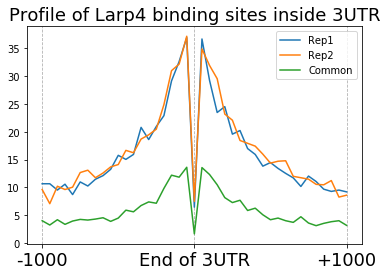

In [14]:
PATH_FOLDER=os.getcwd() 
INPUT_read_file = PATH_FOLDER+'/'+"13439_Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"12850_Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"
#for input_genelist in INPUT_LIST:

Name1="/hg38_3UTR_end.bed"
INPUT_gene_list = PATH_FOLDER + Name1

upstreamExtension =1000
resolution = upstreamExtension/20
window_size = resolution

num_profile_points= 2*upstreamExtension / resolution +1
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile3   = Get_Summit_Profile(INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='Rep1')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='Rep2')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3[0:num_profile_points], label='Common')

#ax.set_title(Name1[:-4])
ax.set_title("Profile of Larp4 binding sites inside 3UTR", size=18)

ax.legend()
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on peak Summit 
Number of transcripts: 18328
Number of reads: 100035
....................................................
Profile on peak Summit 
Number of transcripts: 18328
Number of reads: 112488
....................................................
Profile on peak Summit 
Number of transcripts: 18328
Number of reads: 18368


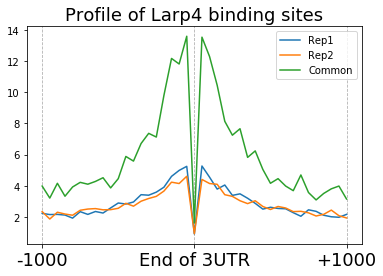

In [15]:
PATH_FOLDER=os.getcwd() 
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"
#for input_genelist in INPUT_LIST:

Name1="/hg38_3UTR_end.bed"
INPUT_gene_list = PATH_FOLDER + Name1

upstreamExtension =1000
resolution = upstreamExtension/20
window_size = resolution

num_profile_points= 2*upstreamExtension / resolution +1
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile3   = Get_Summit_Profile(INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='Rep1')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='Rep2')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3[0:num_profile_points], label='Common')

#ax.set_title(Name1[:-4])
ax.set_title("Profile of Larp4 binding sites", size=18)

ax.legend()
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on peak Summit 
Number of transcripts: 9239
Number of reads: 100035
....................................................
Profile on peak Summit 
Number of transcripts: 9239
Number of reads: 112488
....................................................
Profile on peak Summit 
Number of transcripts: 9239
Number of reads: 18368


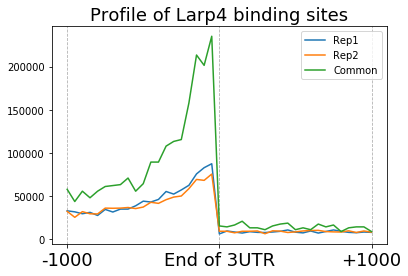

In [15]:
PATH_FOLDER=os.getcwd() 
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"
#for input_genelist in INPUT_LIST:

Name1="/hg38_3UTR_Positive_End.bed"
INPUT_gene_list = PATH_FOLDER + Name1

upstreamExtension =1000
resolution = upstreamExtension/20
window_size = resolution

num_profile_points= 2*upstreamExtension / resolution +1
norm_profile_b   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2_b   = Get_Summit_Profile(INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile3_b   = Get_Summit_Profile(INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_b[0:num_profile_points], label='Rep1')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_b[0:num_profile_points], label='Rep2')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3_b[0:num_profile_points], label='Common')

#ax.set_title(Name1[:-4])
ax.set_title("Profile of Larp4 binding sites", size=18)

ax.legend()
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on peak Summit 
Number of transcripts: 9091
Number of reads: 100035
....................................................
Profile on peak Summit 
Number of transcripts: 9091
Number of reads: 112488
....................................................
Profile on peak Summit 
Number of transcripts: 9091
Number of reads: 18368


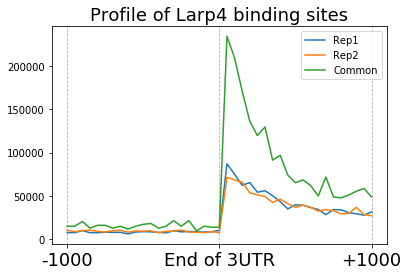

In [16]:
PATH_FOLDER=os.getcwd() 
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"
#for input_genelist in INPUT_LIST:

Name1="/hg38_3UTR_Negative_End.bed"
INPUT_gene_list = PATH_FOLDER + Name1

upstreamExtension =1000
resolution = upstreamExtension/20
window_size = resolution

num_profile_points= 2*upstreamExtension / resolution +1
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile3   = Get_Summit_Profile(INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='Rep1')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='Rep2')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3[0:num_profile_points], label='Common')

#ax.set_title(Name1[:-4])
ax.set_title("Profile of Larp4 binding sites", size=18)

ax.legend()
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

In [17]:
norm_profile_b += norm_profile[::-1]
norm_profile2_b += norm_profile2[::-1]
norm_profile3_b += norm_profile3[::-1]
#norm_profile = norm_profile[::-1]
#norm_profile2 = norm_profile2[::-1]
#norm_profile3 = norm_profile3[::-1]


In [19]:
norm_profile_b = norm_profile_b/(9091+9239)
norm_profile2_b = norm_profile2_b/(9091+9239)
norm_profile3_b = norm_profile3_b/(9091+9239)

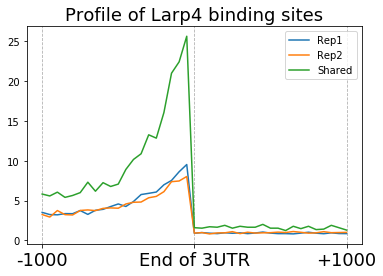

In [21]:
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_b[0:num_profile_points], label='Rep1')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_b[0:num_profile_points], label='Rep2')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3_b[0:num_profile_points], label='Shared')

ax.set_title("Profile of Larp4 binding sites", size=18)

ax.legend()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX8AAAEUCAYAAADDdzb+AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzsnXl8VNX5/98nM1kmK0kICZCEEJawrwFlEQIqWlSsVmsVrVYtte3X5Wdd269166KttlYFrVKXqvita0XEnSWiCISwE8IaICEL2fdlZs7vjzsJSZjsczP3Juf9es1rJmfOveeZO58898xznnOOkFKiUCgUiv6Fj7cNUCgUCkXvo5y/QqFQ9EOU81coFIp+iHL+CoVC0Q9Rzl+hUCj6Icr5KxQKRT9EOX8vI4TwEUI8IoQ4KoSwCyGkq/y1xtfN6j4ihJBCiARv2NrMjgVCiO+FEBUue27ypj3eRgiR0pXr4O679aAtG4QQWR2VGRUz2Wp2lPN30ewfuPmjUgixXQhxpxDColPTNwIPA+uBW4AbdGrHIwghwoEPgCDgN2j2prZTv/GGldxLJvYIIcRgIUSJy+Z7vG2PAoQQNwkh7vK2HX0Nq7cNMCBvA2sBAQwBbgKeAcYDy3Ro70KgDLhVtpxx93PgNh3a6ykzgAHALVLKD7xtjA48h/7/F7393S5C07MZcGfrTUAC2v+hwkOonv/ZpEsp35RSviGlfBI4BzgF3CqEiG7rICGErxAioBvtxQClrRw/UsoGKWVtN86nNzGu52KvWtGKHlz/5udYAlwBPOYZq9zT29+tlLJeSlnXW+31BDPZanaU8+8AKWU5sBmtN5IILUIZ44UQfxNCZAO1wLmNxwkhbhVCpAshaoQQZUKIL4QQc5u9n+KK+y4AhjULNb3mer/TcWEhRJgQ4kkhxGEhRJ0Q4rQQ4m0hRGJnP6cQYpIQ4kMhRJEQolYIsV8IcV/zcJcrFvu668/1jTZ3to0O2h8jhFghhNjnGkuodoXcbnVTt93r33gdhRAXuMYmqoUQeUKIfwghgttoPwRYDrwAbOvB57hdCHHQdQ0PCiFud1PH3XjOay67w4QQLwghClzn+FYIcY6bc4QLIV4WQhQKIapcsfLpbdjU5jiAEGKISyslruv0uRBitJtzJAgh3hdClLseHwkhhrvOsaET18VHCHGXEGK36/stF0JkCiH+JYTwbctW1+v5tPwfkUKIlGZ1Rgkh3hBC5Aoh6l02/VUIEdTKhjghxCtCiOOu/5MCIcR3QogbO7K/L6LCPh0ghBDASNefha3efguoAZ4GJJDrOuZJ4D5gK/BbIAQtZLReCHG5lHItkIEWL/8dMBD4f65zHumifWHAd0A88AqwDxgM/ArYIoRIllIe7+AcycBGoAHNAeYBlwFPApOBpa6qdwE/cH2WP7k+g6dIAeYBa4BjaGMKVwMvCyGipJR/dnOM2+vvYhpwFfAy8G+0m+wdwAQhxIVSSmerc/0ZsKB9H1O7+RluR/tl9E+gArgWeFYIESGlfLST5/gcOI326yMSuBv4RAgxXEpZAdqvHFe9GcAbwPfAFOAroKgL9gahjdd8j6bT4cCdwEdCiAlSSoervUjgGyAaeBHtez8PbZwqyM153fE712f62HUOh6u9JYA/mvbccRfad9P8fwSXDbhueOuAUrTrnoOm2TuAOUKI+VLKBiGEFfgSGAqsAA4CYcAk12d5nf6GlFI9tIhLCpoD+T2a0KLQhPGyq3xzs7qPuMo2ANZW50kCnMAmwK9Z+RA0gWYBlmblG4AsN/a8pn09Lcoa201oVvYPNAc4uVXdYUA58FonPvu3gB2Y1KxMAO+42ju/WflNrrKUTl7XRpuTO6gX5KbMx3V9ygDfzlx/1/vS9fhhq/J/uMp/0qr8XDRndE0rLdzTRe1UALHNyv3QOgANrcrdfbevuc6xolX51a7yXzQrW+Yqe7RV3btc5Vmtys/SmKtMAve1Kr/XVX5Rs7K/uMqWtqrbWL6hE9coHdjfiXpt2XrW/4jrvV3AASCkVfkVLttucv09yd3n7c8PFfY5m0fRel4FaMK6GVgN/NBN3WeklPZWZZejOc6/SCnrGwullKeAV9Gccnd7li1w/SpZitZ7yxFCDGx8AFVoPbpFHZxjEDAbWC2l3N3MXgn80fXnFZ6wtz2klFXNbApw9TYjgC+AUGCMm8PcXf9GMqWU/21V9oTruenzuHrRLwNfSin/0137Xbwlpcxu/MP1/f8d7Rf2ZZ08x99b/b3O9TyqWdkP0W5WT7eq+wLaDb+zOIFnO9HeZWi/qt5uVfepLrRVBgwVzUKfPUUIMRHNqa8C/FvpfxPa/0Cj/stczwtcmu/3qLDP2bwEvIvWS6gCDkop2xrcPOimbLjreZ+b9xrLEoG0nhjpIgotNLAI7Ybljtbhjda0Z2+G6/hOjx10F1cs/hHgx0CcmyrhbsrcXf9GzgpJSSlzhRCltPw896OF9dzd3LuKuzDYftdzZ6/h0eZ/SCmLtHs8kc2KE4FcqY1HNa9bJ4Q4ivtr5Y5T8uyB58awUfP2hgNbZatQmZSywHU9O8Nvgf8C3wghTqH15j8B3mveSeoiY13Pj7oe7oh22XpcCPFH4EEgVwixE/gaeFdK2e0xHjOjnP/ZHJJSftXJutW6WtIxjSlxX6HF583MKuBStJtvKpoTcgCL0WK97n6l9uj6CyEGo8WiX9f+FI1jO0Ndz5Gustzmv0z0RLri7G7QI1WzrbY83p6UcrMQYgRwEdr4ywLgOuB/hRBz2+lgtUejjU8Dn7VRp6SZDf8rhHgFuAQtzn8rcK8Q4i9Syvu70b6pUc7f8zT23MZz9uDtuFZ1espptHGE0C7csFpzzPU83s17Y9CcrqfsdYsQYgCa439DSnlbq/cu6OZpx7YucDn7AZz5PNFAAPAL16M1D7geVwPvdadNPP+dN55rkRAitHnvXwjhj/aroKTNI7tHFjBSCOHTvPfvCp8M6OxJpJSVwPuuB0KIX6ElGNwC/LW9Q9soP+R6dnRW/1LKo2hzOZ4TWmrw58B9QoinpZQFnTlHX0HF/D3PajSx3tsqhW0w8DPgOLDDEw25/hHfAmYKIa5yV6ej+KZL8N8BlwkhJjQ7TqD9RAb40BP2tkNjD7RFb9N1zc5K9ewkSUKI1qGcxt5d41jAMTTH3vrxiOv9f7v+3tzJNpcKIWIb/xBC+KH9anGgZTF5io/QMpN+06r8l2jjI57mY7QMsmtblXd6BrQrDt+adNdzRAeHVwLhLk02ZwewF7hNuElrFkJYhRARrtdhzf8fAVwhr8ZQXWdDZX0G1fP3MFLKTCHEX9FSPVOFEP/hTKpnMFrGRHs/t7vK74A5wDtCiHfQBnnr0QaWFwPb0TJ02uNOtFTPb4QQjamel6L9RF8lpfzaA3beLIS42E35dinlp0KIL4DrhRA1aHn2w9B648doGX/uLHuAN4UQL6P1EBegpX5uBP4DIKUsw02PXgjRmNK7R0rZmR5/IwfR0mtfRMv8uQ4tHfNxKeXJbnyGtngVTU+/F0IMR7s5TUW7UR3B8//XT6J9lleFEDPRsmvOQ0sUKKTtnnlzMoQQ3wNb0CZNDnZ9hnrg/zo49ns0PT4vhPgO7Wa6zjXmcAPaIPVuV0hnHxCINo5zJVoH5jW07/8lIcT7QCbaDWU6Wudii5QysxOfoU+hnL8OSCnvF0IcRsu1fwJN4FuA66SU33i4rTIhxBy0XuCP0bKN7EA2WsbDyk6cI00IMRtt0OxXaLnbR9F6yq0zSrrLL9so/yfwKXA92rW6DG29o0NoN7YGNGfXVdLRcuT/iLaUQjnwPPDb1gOXHuQ5tJ737WjzLk4Ad0kp/+HJRqSU9UKIC9FCJT8EfoR2w7wQLQMnwcPtFbqydJ5Gy36TaDn+C1zt1nTiNE+jdUbuQMuvL0Bz6n+WUu7q4Ni/o4WzrkL7Ln1cbRdIKXcKIaaiOfklrvcr0EJVr6EN6oKWufcBWlruUrRfTifQ5qt4SuOmQrhyYBWKPoPQZs++LqW8ydu29GVc6biFwD9bj9UojI+K+SsUig4RQtjcFD/gev6yN21ReAYV9lEoFJ1hrRDiOFo4zQc4Hy0O/x1nBtAVJkI5f4VC0RnWAD9Fmx1tQxtTehptiQlPJjAoegkV81coFIp+SK/2/AcOHCgTEhK6dWx9fT1+fn6eNUihcKH0pdCbnmhs+/bthVLKKE/a06vOPyEhgbS07i1ps2HDBlJSUjxrkELhQulLoTc90ZhrvMWjmCbbZ/Lkyd42QdGHUfpS6I3RNGYa519RUeFtExR9GKUvhd4YTWOmcf5Hj+q6tpiin6P0pdAbo2lMpXoqFIpepaGhgezsbGpre20Pe0MQFhZGRkb7O58GBAQQGxuLr69vu/U8gWmcf3ezhBSKzqD01XtkZ2cTEhJCQkICZy/U2Xepq6vD39+/zfellBQVFZGdnc3w4cPbrOcpTBP2iYjoaNVXhaL7KH31HrW1tURGRvYrxw9gtbbf1xZCEBkZ2Wu/iEzj/NPT0zuupFB0E6Wv3qW/OX6A6uqON57rzetiGuevUPSEL49/SX5VvrfNUCgMg2mcf3h4v9toR+EhTlWe4u4Nd/PB4Q/arKP01b+wWCxMmTKFCRMmcNlll1Fa2tl96M/m+eefZ+TIkQghKCwsbLOexWLpdht6YBrnb7QJEgrzkJqdCkB1Q9s/u5W++hc2m42dO3eyd+9eIiIiWL58ebfPNWfOHL766iuGDRvWbr3AwMBut6EHHTp/IUScEGK9EGK/EGKfEOJOV/kjQogcIcRO12OxnoZu3LhRz9Mr+jAbsjcAUGNve8Mppa/+y6xZs8jJyWn6+69//SszZsxg0qRJPPzwwwBkZWUxZswYli5dytixY7nqqquaYvhTp07tVLaY0SZ5dSbV0w78RkqZLoQIAbYLIRo3b/i7lPIp/cw7g1p9VNEdqhuq2Zq7FYBae9tZFEpf3uHRj/ex/1S5R885bkgoD182vlN1HQ4HX3/9NbfccgsAX3zxBYcOHWLr1q1IKVmyZAmpqanEx8eTmZnJv/71L+bMmcPNN9/MihUruOeeTu9hbzg67PlLKXOllOmu1xVou90P1duw1vTH7ABFz/k+93sanA0A1Dradv5KX/2LmpoapkyZQkxMDPn5+Vx44YWA5vy/+OILpk6dyrRp0zhw4ACHDh0CIC4ujjlz5gBw/fXXs2nTJq/Z7wm6NMlLCJEATEXbjHwO8D9CiJ8CaWi/DkrcHLMMWAYQHx/fbUPnz5/f7WMV/ZfU7FSCfYOJCYppt+ev9OUdOttD9zSNMf/q6mouuugili9fzh133IGUkgcffJBf/OIXLepnZWWd1UHoaochJCSkx3Z7kk4P+AohgoH3gbuklOXAC8AIYAqQi7arz1lIKV+SUiZLKZOjorq/HPWuXbu6fayif+KUTlKzU5k9ZDahfqHtxvyVvvongYGBPPvsszz99NPY7XYuuugiXnnlFSorKwHIycmhoKAAgBMnTrB582YAVq1axdy5c7vUVmfy/HuTTjl/IYQvmuN/S0r5AYCUMl9K6ZBSOoGXgZn6mQklJWf9qFAo2iWjOIPTNadJiUshwBrQbs9f6av/MnXqVCZNmsTbb7/NokWLuO6665g1axYTJ07kqquuahqoTUpKYvny5YwdO5aSkhJ++ctfAvDss88SGxtLdnY2kyZN4tZbb3XbjsNhrN0uOwz7CO23zb+ADCnl35qVD5ZS5rr+vALYq4+JCkX3SD2ZikAwd+hcvjr+Facdp71tksIgNPbsG/n444+bXt95553ceeedLd7PysrCarXy5ptvnnWuO+64gzvuuEMfQ3WkMzH/OcANwB4hxE5X2W+Ba4UQUwAJZAG/cH+4Z5g2bZqep1f0QTZmb2Ry1GTCA8I77PkrfSn0xmh5/h06fynlJsDdyMZaz5vTNsXFxYSGhvZmkwoTU1BdwL6ifdw5TevB2ay2dp2/0peiPRISEti7t2fBDbvdbqhZvqaZ4ZuVleVtExQm4pvsbwCYFzsP6Nj5K30p9Ka+vt7bJrTANM5foegKG7M3MjhoMKMGjAIgwBrQbraPQtHfMI3zT0xM9LYJCpNQ56jj+9zvmRc7rykXO8ASgF3amyZ8tUbpS6E3fn5+3jahBaZx/kabIKEwLtvytlFjr2F+7JmJWwHWAKDtJR6UvhR6Y6R4P5jI+atJOIrOsvHkRmxWGzMHn5l6YrPagLadv9JX/8KTSzovXbqUpKQkJkyYwM0330xDg/tflzU1xgo7msb5KxSdQUpJanYq5w4+F3/Lmf1SO3L+iv6FJ5d0Xrp0KQcOHGDPnj3U1NSwcuVKD1qqH6Zx/pGRkd42QWECDpUe4lTVqRYhHzgT9qlxuO99KX31X3q6pPPixYsRQiCEYObMmWRnZ7ttx2hhny4t7OZNxo/3zgJQCnPRuHHLebHntSgPsLicfxsZP0pfXuLTByBvj2fPGTMRfvBEp6p6cknnhoYG3njjDf7xj3+4bctms/X8s3kQ0/T8U1NTvW2CwgRsPLmRcZHjGBQ4qEV5RwO+Sl/9Cz2WdP7Vr37FvHnzOO+8lh2PRlovKeFtTNPzVyg6oqS2hF2nd3Hb5NvOek/F/A1KJ3vonsbTSzo/+uijnD59mn/+85+9Yr8nME3P32pV9ylF+2zK2YREnhXvh2ZhnzZi/kpf/RNPLOm8cuVKPv/8c95++218fEzjUs3j/Lu6drai/7ExeyMDbQMZGzn2rPdsvu33/JW++i89XdL5tttuIz8/n1mzZjFlyhQee+wxt+0YbS6Jabo76enpauVFRZs0OBv4NudbLkq4CB9xdp+msefflvNX+upfeHJJZ7vd3qk2q6qqCAoK6oa1+mCann95uWc3eVb0LdLz06lsqGxayK01jTH/trJ9lL4UeuN0Or1tQgtM4/wVivb4LOsz/Hz8OHfwuW7fb5zwpQZ8Fd3BE0s6Gw3TOP/k5GRvm6AwKDsKdvD+wfe5YtQVBPq63zDD4mPBz8evzQFfpS+F3hhtMxfTOP/8/Hxvm6AwIDX2Gh769iGGBA/h7ul3t1u3vd28lL4UetPWmj/ewjTO/+TJk942QWFAnk1/luPlx3ls9mNt9vobaW9DF6Uvhd4o569QeIjt+dt5K+Mtrkm6psUKnm1hs9rUhi4KhQvTOP9Ro0Z52wSFgahuqOb33/6+U+GeRtoL+yh99T/++Mc/Mn78eCZNmsSUKVPYsmULCQkJFBYW6tKev/+ZVWYfeeQRnnrqKV3a6SymyfNvfuEUimd3PMuJihO8ctErHYZ7GgmwBLQ54Kv01b/YvHkza9asIT09HX9/fwoLC3u8x67dbm93pnjr5SG8jWl6/n0tzUrRfdLy0ngr4y2uHXMtM2JmdPq49nr+Sl/9i9zcXAYOHNh00x84cCBDhgwB4LnnnmPatGlMnDiRAwcOALB161ZmzZrF1KlTmT17NpmZmQC89tprLFmyhIULF3L++ecD7peEBnj88ccZPXo0c+fObTrem5im569QgBbueejbh4gNjuWuaXd16dgAawAltSU6WaboDk9ufZIDxQc8es4xEWO4f+b97dZZtGgRjz32GKNHj+aCCy7gmmuuYf58bU2ogQMHkp6ezooVK3jqqadYuXIlY8aM4ZtvvsFqtfLVV1/x29/+lvfffx/QZofv3r2biIiINpeEDgoK4v3332fnzp3Y7XamTZvG9OnTPfq5u4ppnP+gQYM6rqTo8zyT/gzZldldCvc0YrPaqHW47/krffUvgoOD2b59O9988w3r16/nmmuu4YkntBVGr7zySgCmT5/OBx98AEBZWRk33ngjhw4dQgjRInPnwgsvJCIiAmi5JDRoy0gcOnSIiooKlixZ0pTrv2TJkl77rG1hGuc/evRob5ug8DLb8rbx9oG3WTp2aZfCPY3YrDZqGtzH/JW+vENHPXQ9sVgspKSkkJKSwsSJE3n99deBM+M/Foulad2ehx56iAULFvDhhx+SlZVFSkpK03mar9fT1pLQzzzzjOFWjjVNzL/1xgmK/kXjZK64kDjumHpHt87R3oCv0lf/IjMzs2mTFoCdO3cybNiwNuuXlZUxdOhQQIvzt0VbS0LPmzePDz/8kJqaGioqKlosJOctjHUrUijaYEvuFnIqc1h+/vIuh3saaW/AV9G/qKys5Pbbb6e0tBSr1crIkSN56aWXWLNmjdv69913HzfeeCN/+MMfuOSSS9o876JFi8jIyGDWrFmAFl568803mTZtGldeeSWTJ09m0KBBzJjR9V+unkZIKXutseTkZJmWltatYzdv3tx0QRX9jxd2vsALu17g++u+77bzf2HXC6zYuYIdN+zA6tOy36P01XtkZGQwduzZey70dSorKwkODu6wnrvrI4TYLqX06AJUpgn7qH/M/k1GcQbDQod12/EDBFq1Y+scdWe9p/Sl0JvOOP7exDTOv7u/GBR9g4ziDLc7dHWFpq0c3SzxoPSl0Juqqipvm9AC0zj/1jvvKPoPJbUl5FXlMTaih87f2rbzV/rqXXoz3GwUOrOZS29elw6dvxAiTgixXgixXwixTwhxp6s8QgjxpRDikOs5XH9zFf2RjOIMgJ73/K3tb+Wo6B0CAgIoKirqlzeA9pBSUlRUREBAQK+015lsHzvwGylluhAiBNguhPgSuAn4Wkr5hBDiAeABQLek3XPOOUevUysMTuMM0J72/Bu3cnTn/JW+eo/Y2Fiys7M5ffq0t03pVaSUHa7vExAQQGxsbK/Y06Hzl1LmArmu1xVCiAxgKHA5kOKq9jqwAR2df3Z2tlp5sZ+SUZTBkKAhhPmH9eg8TZu4u5nlq/TVe/j6+jJ8+HBvm9HrHDp0yFAa61LMXwiRAEwFtgDRrhsDQB4Q3cYxy4QQaUKItJ7c6XNycrp9rMLcHCg+0OOQD7S/ibvSl0JvjKaxTjt/IUQw8D5wl5SyvPl7UgveuQ3gSSlfklImSymTo6KiemSsov9R1VBFVnkWYyLG9PhcKuavUJyhU85fCOGL5vjfklJ+4CrOF0IMdr0/GCjQx0SNpKQkPU+vMCiZxdrSt+Mix/X4XO1l+yh9KfTGaBrrTLaPAP4FZEgp/9bsrdXAja7XNwIfed68M1gsFj1PrzAojZk+nuj5tzfgq/Sl0BujaawzPf85wA3AQiHETtdjMfAEcKEQ4hBwgetv3di/f7+ep1cYlIyiDCIDIomy9Txk2N6Ar9KXQm+MprHOZPtsAtrKTzrfs+YoFC3JKM5gTOQYj2yB117YR6Hob5hmhm9MTIy3TVD0MnWOOo6WHmVcRM/j/QBWHyu+Pr5uwz5KXwq9MZrGTOP8+2NecH/ncMlh7NLukXh/IwHWALc9f6Uvhd4YTWOmcf6bN2/2tgmKXmZ/sRYj9USOfyM2i/utHJW+FHpjNI2Zxvkr+h8Hig4Q4htCbLDnpru31fNXKPobpnH+NpvN2yYoehlPDvY20tZuXkpfCr0xmsZM4/zVwlv9C7vTzsGSgx6N94OW668WdlN4A6NpzDTOf8uWLd42QdGLHCs7Rp2jrscrebYmwBrgNuav9KXQG6NpzDTOv6ZGxWn7E43LOHtiWYfm2Cw2tzF/pS+F3hhNY6Zx/or+xf6i/QRYAkgITfDoeduK+SsU/Q3TOH+1wXb/4kDxAUZHjMbi49n1UNrK9lH6UuiN0TRmGud/7Ngxb5ug6CWc0qmt4e/heD9o6/u4i/krfSn0xmgaM43zz8vL87YJil4ipyKHyoZKXZy/zdd9to/Sl0JvjKYx0zh/Rf+hcWbvmEjPpnmCNuBb56jDKZ0eP7dCYSZM4/zHjfNs1ofCuBwoPoBVWBk1wPP7nba1m5fSl0JvjKYx0zh/h8PhbRMUvURGUQYjBozAz+Ln8XO3tayz0pdCb4ymMdM4/8zMTG+boOgFpJRkFGd4dDG35rS1oYvSl0JvjKYx0zh/Rf+goLqA4tpijy/r0Eh7WzkqFP0J0zj/oUOHetsERS+g18zeRtpy/kpfCr0xmsZM4/xjYz23rK/CuOwv3o9AkBSepMv5G2P+1fbqFuVKXwq9MZrGTOP8jbYokkIfDhQdYFjoMAJ9A3U5f1vZPkpfCr0xmsZM4/wV/YOM4gxdJnc10taAr0LR3zCN8w8ODva2CQqdKa0tJbcqV7dMH2g75q/0pdAbo2nMNM4/OTnZ2yYodCajOAPw7J69rWkrz1/pS6E3RtOYaZy/0TY/VniexkwfPcM+bfX8lb4UemM0jZnG+dfV1XnbBIXOZBRlMCRoCGH+Ybq10VbPX+lLoTdG05hpnL+ibyOlZHfhbl1DPgC+Pr5YhVUN+Cr6PaZx/nPnzvW2CQodOVZ+jJzKHGYN1n/DC3e7eSl9KfTGaBozjfM/ePCgt01Q6EjqyVQA5sXO070td7t5KX0p9MZoGjON8y8oKPC2CQod2Zi9kdHhoxkcPFj3tmxW21lhH6Uvhd4YTWOmcf6KvktZXRk7CnYwP3Z+r7SnNnFXKEzk/CdMmOBtExQ68d2p73BIB/Pjesf52yy2s8I+Sl8KvTGaxjp0/kKIV4QQBUKIvc3KHhFC5Aghdroei/U103hpUgrPseHkBiICIpgQ2Tv/HO56/kpfCr0xmsY60/N/DbjYTfnfpZRTXI+1njXrbA4dOqR3EwovYHfa2ZSziblD52LxsfRKm+4GfJW+FHpjNI116PyllKlAcS/YouiH7Dq9i/L68l6L94O2uJvK81f0d3oS8/8fIcRuV1govK1KQohlQog0IUTa6dOnu91YXFxct49VGJeN2RuxCiuzh8zutTZtVttZYR+lL4XeGE1j3XX+LwAjgClALvB0WxWllC9JKZOllMlRUVHdbA6io6O7fazCuKSeTGV6zHSC/XpvxUN3MX+lL4XeGE1j3XL+Usp8KaVDSukEXgZmetass0lLS9O7CUUvc7LiJEfKjvRqyAe0nn/rmL/Sl0JvjKaxbjl/IUTzmThXAHvbqqtQtEVqtjarNyU2pVfbDbBqMX+ndPZquwqFkbB2VEEI8TaQAgwUQmQDDwMpQogpgASygF/oaCMAoaGhejeh6GVSs1MZHjacuNDejYU27ua4kOa0AAAgAElEQVRV56hrWuJZ6UuhN0bTWIfOX0p5rZvif+lgS7tMmzatt5tU6EhVQxXb8raxdOzSXm+7+T6+jc5f6UuhN0bTmGlm+G7atMnbJig8yOZTm2lwNvTKQm6tCbRqm8M3H/RV+lLojdE0Zhrnb7fbvW2CwoNszN5IiF8IUwZN6fW23W3oovSl0Bujacw0zl/Rd3BKJ6nZqcwdMhdfH99eb78x5l/jqOmgpkLRdzGN8583r/fDAwp92Fe4j+LaYubFeec7bR7zb0TpS6E3RtOYaZz/vn37vG2CwkNszN6Ij/Bh7hDv7GzkbhN3pS+F3hhNY6Zx/kVFRd42QeEhUrNTmRI1hQEBA7zSvjvnr/Sl0Bujacw0zl/RN8ivyiejOKPX1u53R9OAr4r5K/oxpnH+kydP9rYJig6obqjmJ2t+wn0b72PX6V1u66TmaLN6e3tJh+Y0Dfg2y/ZR+lLojdE0ZhrnX1FR4W0TFB3w6bFP2Ve0jw3ZG7h+7fUs/WQpa4+upcHZ0FQn9WQqQ4OHkhiW6DU73Q34Kn0p9MZoGjON8z969Ki3TVB0wLsH32XkgJGs//F6fnvObymrL+P+b+7n4vcv5uXdL5NXlcf3ud8zP3Y+Qgiv2eku5q/0pdAbo2nMNM5fYWz2F+1nX9E+rhp9FUG+QVw75lpW/3A1y89fzoiwETy741kuev8iah21Xg35APj6+OIjfM5a2VOh6E90uLaPUUhISPC2CYp2eO/ge/hb/Lk08dKmMh/hw7zYecyLncehkkO8lfEW2ZXZJMcke9FSEEJoG7o0281L6UuhN0bTmGmcf0REhLdNULRBVUMVnxz9hIsSLiLMP8xtnVHho3hk9iO9a1g7BFhabuii9KXQG6NpzDRhn/T0dG+boGiDtcfWUm2v5urRV3vblE7TehN3pS+F3hhNY6Zx/grj8m7mu4wKH8XkKGOlsrWHu318FYr+hGmcf3h4m3vEK7zIvqJ9ZBRncPXoq72awdNVAiwBLSZ5KX0p9MZoGjON8zfaBAmFxruZ7xJgCeCSxEu8bUqXaL2Ju9KXQm+MpjHTOP+NGzd62wRFKyrrK1l7bC0XD7+YUD9jbVHXEa3DPkpfCr0xmsZM4/yllN42QdGKtcfWUmOvMdVAbyOte/5KXwq9MZrGTOP8zRRP7g9IKXn34LskhScxceBEb5vTZWxWW4tsH6Uvhd4YTWOmcf7z53t3VqiiJfuK9nGg+IDpBnobCbAEtJjkpfSl0Bujacw0zn/XLverRCq8w7sH38VmtbE4cbG3TekWrfP8lb4UemM0jZnG+ZeUlHjbBIWLivoKPj32KT8Y/gNC/EK8bU63aIz5N8Zhlb4UemM0jZnG+SuMw9qj5h3obcRmtSGR1DvrvW2KQuEVTOP8p02b5m0TFJwZ6B0bMZbxkeO9bU63aVzWuaZBC/0ofSn0xmgaM43zLy4u9rYJCmBP4R4ySzK5avRVphzobaRxN6/GQV+lL4XeGE1jpnH+WVlZ3jah31NUU8RTaU9pA73DzTnQ20jTPr6uQV+lL4XeGE1jplnSWeFdtuVt4/7U+ymvL+fhWQ8T7BfsbZN6hLutHBWK/oRpnH9iovf2fO3POJwOXtrzEi/uepH4kHheuOAFkiKSvG1Wj2naytEV9lH6UuiN0TRmGucfEmLOlEIzU1hTyAPfPMCW3C1cmngpD537EIG+gd42yyM0Dfi6wj5KXwq9MZrGTBPzN9oEib7OltwtXLX6KnYV7OKx2Y/xp7l/6jOOH84M+DY6f6Uvhd4YTWMdOn8hxCtCiAIhxN5mZRFCiC+FEIdcz8ZaqFrRbZzSyYqdK/j5Fz8n1D+UVZes4opRV5g6s8cdKuav6O90puf/GnBxq7IHgK+llKOAr11/60pkZKTeTSiAF3e9yAu7XuCyEZfxf5f8H6PCR3nbJF1oivm7nL/Sl0JvjKaxDp2/lDIVaJ2gejnwuuv168APPWzXWYwfb94JRWbh25xveXHXi1w+4nL+MOcPfSrM05rWef5KXwq9MZrGuhvzj5ZS5rpe5wHRbVUUQiwTQqQJIdJOnz7dzeYgNTW128cqOiavKo8HvnmAkeEj+d25v+tzYZ7W2HxbDvgqfSn0xmga6/GAr9RWxmpzlwIp5UtSymQpZXJUVFRPm1PoQIOjgd9s/A0Nzgb+Nv9vTSGRvoyfjx8CoWL+in5Ld51/vhBiMIDrucBzJrnHajVNVqrp+Nv2v7H79G4enf0oCWEJ3jZHF3LLamhwOJv+FkK0WNZZ6UuhN0bTWHed/2rgRtfrG4GPPGNO28ydO1fvJvolX2R9wZsZb3L92Ou5KOEib5ujC6t3nWLuk+t59dtjLcqb7+Or9KXQG6NprDOpnm8Dm4EkIUS2EOIW4AngQiHEIeAC19+6kp6erncT/Y6ssix+/93vmRQ1ibun3+1tc3Th/7ae4M7/24HDKTl6uqrFe81381L6UuiN0TTW4e8QKeW1bbx1vodtaZfy8vLebK7PU2Ov4e6Nd+Pr48tT857C1+LrbZM8zr82HePxNfuZPzqK3LIacstaxvebh32UvhR6YzSNmWaGr8Kz/GnLnzhccpg/n/dnBgcP9rY5HkVKyXNfH+LxNfu5eHwML/10OsMig8hr5fybh30Uiv6GaZx/cnKyt03oM3x46EP+e/i/LJu0jLlDjRWH7ClSSp747ABPf3mQK6cO5fnrpuJvtTA4LIBTZTUt6gZYz4R9lL4UemM0jZnG+efn53vbhD5BcW0xT2x9gnNizuGXk3/pbXM8itMpeeijvfxz41GuPzeep66ejNWiSTwmLICKWjuVdfam+gHWgKadvJS+FHpjNI2ZxvmfPHnS2yb0CV7d+yq1jlp+e85vsfhYvG2Ox7A7nNzz3i7e/P4Ev5iXyOOXT8DH58xEtSFh2tyF5qEfm8XW1PNX+lLojdE0Zhrnr+g5BdUFvH3gbS5NvJTEAcZaW7wnOJ2Se97dxQfpOfzmwtE88IMxZ81QjgnTlnPIbRb6aT7gq1D0N4w166AdRo3qmwuM9SYv7X4Jh9PBbZNv87YpHuWpLzL5785T3LNoNP+z0L1OBjc5/zM9/wBrQNOAr9KXQm+MpjHT9Pz9/f29bYKpyanM4f1D73PFqCuIC4nztjkeY9WWE6zYcIRrZ8bz6wUj26wXHao5/xZhH+uZsI/Sl0JvjKYx0zj/vXv3dlxJ0SYv7noRH3xYNmmZt03xGOsPFPDQR3tZkBTF45ePb3cxugBfC5FBfi3DPhYt7COlVPpS6I7RNGYa56/oPlllWaw+spofJ/2YmKAYb5vjEfbmlPHrVemMHRzC89dNa8rqaZOS48SGWlqEfWxWG07ppMHZoLO1CoXxMI3zHzRokLdNMC0rdq7A3+LPrRNv9bYpHiG7pJqfvbaN8EA/XrlxBkH+7QxdlZ+C926Bf0xiqfisRdincTevGnuN0pdCd4ymMdMM+I4ePdrbJpiSzOJMPs36lFsn3kqkzVg7CXWHspoGfvbqNmobHKy69RwGuWL5Z2Gvg83LIfUpcNrBamO0PM6p0pbZPqDt5qX0pdAbo2nMND3/TZs2edsEU7J853JCfEO4afxN3jalx9TZHfzijTSyiqp46YZkRkWHuK948AtYMQu+fhQSU+DXW2DodAY5cimvtVPlmujVtJWjo1bpS6E7RtOYaZy/ouvsOb2H9SfXc+P4GwnzD/O2OT3C4ZTc/95uvj9azFNXT2bWCDe/YoqPwqprYNXVIAQsfR+uXQURwyEigfC6UwDklWuhH5ul5T6+CkV/wjRhH6OlSZmB53c+T7h/ONePu97bpvSI7w4X8tia/WTn5fOnuQO4POwI7NkMlQVQVaA9V+bDsVSw+MGFj8E5vwSr35mThCdgqztNAHXkltYyIiq4Rcxf6UuhN0bTmGmc/6xZs7xtQpf55OgnjBwwkqSIpC4f63A6EELgI7r34ywtL43vTn3HPcn3EOQb1K1zeJuswir+tDaDL/bnc1Xofj4J/AuWtHpIa1bJxxeCB0FQFEy+FlIehFA3q5SGDwcgTpxuSvds7vzNqC+FuTCaxkzj/NPS0gy3Kl57fHn8Sx745gEG+A9g1eJVxIV2fmJVjb2G2768jRMVJ7hlwi1cNfqqJkfVGaSUPLfjOaJsUVyTdE13zPcq5bUNPL/uMK9+eww/iw+PzQ/lhl3PI6KSYO5dLmc/SHu2hWshno5wOf9hIr8p46f5gK/Z9KUwH0bTmGli/pWVld42odOcqjzFw989TFJ4EhLJr9f9mvL6zm3kYHfauS/1PnYU7GBw0GCe3PYkP/jgB7yx/41OxaZPlJ9g+c7lpBeks2zSsi7dNLyNwylZteUEC/66gZe/OcoVU4ey/v/N5qfZDyOkE675N0y8CobPg0FjIDCic44fIDwBgDH+RZwqaxXzd9SaSl8Kc2I0jZmm528W7E4796fej1M6+fuCv5NXlceyL5dxz4Z7WH7Bcnx92t4xS0rJn7b8iQ0nN/DgzAe5bux1bMvbxou7XuQv2/7CK3tf4Wfjf8bVSVc3Zao4pZP9RftZd2Id60+u53DpYQDOiTmHK0dd2Suf2ROUVtdz82vbSD9RysyECF67dBwTY8Ng7X2Qsx1+/AZE9GAxusAI8AthtCjiQ1fYpynbx16LDZsnPoZCYRpM4/zPOeccb5vQKV7Y9QI7T+/kyfOeJC4kjriQOH5/7u/5/Xe/54ktT/C/5/5vm8sQvLT7Jd49+C63TLiF68ZeB8CMmBnMiJlBWl4aL+56kb+m/ZVX9r7C0rFLya/OZ/3J9RRUF2ARFqZHT+eBmQ+QEpfC0OChvfmxe0RBRS03rNzKsaIqnrlmCpdPGaJdo30fwtZ/wrm/hnFLetaIEBCRQEJZftMs3+Yx/4vPubinH0OhaBej+TDTOP/s7GzDrYrXmq25W3l598v8cOQPWZy4uKn8ilFXkFWexSt7XyFxQCJLxy4969gPD33I8zuf57LEy7hz2p1nvZ8ck8zKmJVsz9/OC7te4Nkdz2Kz2pgzZA4L4xcyL3aeKdM5c0pruH7lFvLLa3n1phnMGTlQe6PwMHx0O8TOhAsf9Uxj4QnElOx26/zNoC+FuTGaxkzj/HNycgx14VpTUlvCg988yLDQYTw488Gz3r9z2p0cLz/OX7b9hbiQOObFzmt6LzU7lUc3P8rsIbN5dM6j7S5QNj16OisXreRkxUmibFGmium3JquwiqUrt1Be28Abt8xk+rAI7Y36anjnp2Dxhatf1Z49QfhwIuo/p7ymjup6OwG+WupdraPW8PpSmB+jacw0A75GRkrJQ98+REldCX+d/1cCfQPPquMjfPjT3D+RFJ7EvRvv5WDJQQD2Fu7lno33MDp8NH9L+Vu7YwLNiQuJM7Xjz8yr4Op/bqamwcHbPz/3jOMHWHsvFOyHH70MYbGeazQ8AausJ5oS8spq8RE+BFgC1CQvRb/ENM4/KanrufK9xaoDq9iYvZHfJP+GMRFj2qwX6BvIcwufI9g3mP/5+n/YUbCDX3/9ayICIlhxwQrT5uN3ld3ZpVzz0mZ8BLzzi3OZMLRZuCr9Ddj5Jsy7F0Ze4NmGXRk/8aKgReinxl5jaH0p+gZG05hpnL/FYsz9ZjOKMng67WlS4lK4bsx1HdaPDormufOfo7SulJ9++lOc0smLF7zIQNvAXrDW+2w9Vsx1L28h2N/Ku7+YzchBzdbnydsDa++B4fMh5QHPNx7hyvX3OTPoa7PaqLXXGlZfir6D0TRmGue/f//+bh23LW8bK/espLi22MMWQXVDNfel3kd4QDiPz3683Vh9c8ZFjuPJ854kITSB589/noSwBI/bZhQKK+v47nAhr357jAc/2M1PX9lCdKg/7902m/hIV3hMStjzHrxxJQQMgB+tBD02lw+LQwoLcaKAvGazfGsdtd3Wl0LRWYymMdMM+HaVbXnbeGHXC2zL2wbAG/vf4JFZj7AgfkGPz3209CgfHfmINUfWcLrmNP+66F8MCBjQpXMsiF/gEVuMQlFlHYcLKjl8upJD+ZVk5lVwML+Coqr6pjoDAn2ZO3IgT/xoEgODXeucFB+FT34DR9bBkKlw+Qpt5q4eWHwRYbGMLC1kU2PYx7WbF8bqlCkUumMK5//uwXdZX7meooNFzIiZQVxIXJu97G1521ixcwVp+WkMtA3k/hn3M2XQFB7d/Ch3rL+Dy0dczv0z7yfEr43lgNugrK6Mz459xkdHPmJP4R4swsJ5Q8/j2jHXMiNmhic+pimoqrOzLauYwwWVHDldqTn8gkpKqs/shhXkZ2FUdAgXjI1mdEwISdEhjI4JJirY/8z3Zq+H7/6hrbfv4ws/+AvMuFWfHn9zwhNIrMjjvVZhn5ihfWOHM4VxiYkxlsZM4fzL6srYX7WfbzZ/A8Ag2yCSY5KbJkDFh8RrTn/XCrbnbyfKFsUDMx/gR6N+1JQRs2rxKl7c/SIr96xka95WHp/zOOcMbn/SRXVDNdvytrH6yGrWn1xPg7OBUeGjuDf5XhYnLu43cfpGThZX89NXtnKssAqA8EBfRg4K5uIJMYyICmbkIO0xJMyGj087IbCsTbDmbijMhHE/hIv/DKFDeudDhCcw5PiuFgO+lfWVDB8+vHfaV/RbjKYxUzj/WyfeyojCEQybNoy0vDTS8tLYmreVtcfWAhDiF0JFfYVbp9+Ir8WX26fezvzY+fxu0++49YtbWTp2KXdOu7Npmn9VQxU7CnaQlpfGtvxt7C/cj13aCfcP55qka1gyYgljIsZ0Orbfl8jMq+Cnr2yhpt7BP2+YTvKwcCKDu7BEbV0F5O+D9H/DzrdgQDxc9y6MXqSf0e6IGE6os5SyUm0MyGa1cbrmNJs3byYlJaV3bVH0K4ymMVM4fwAhBIlhiSSGJfLjpB8jpSSrPIttedvYfXo34yLH8aPRP8Lf0r5DmhQ1iXcue4dntj/DWxlv8W3Ot6TEpZCen86+on04pAOrsDJh4ARumnATM6K1Xxe+nppoZELSsoq5+bVt2PwsvHvbbJJi2gmZOZ1Qehzy90LeXu05fy+UZGnv+1hh7t1aKqff2fMhdMeV7hlWm0NNvUMb8FV5/op+SI+cvxAiC6gAHIBdSqnbeqU2W8uFt4QQDA8bzvCw4fw46cddO5fVxoPnPMiC+AU89O1DvJnxJhMHTuTmCTeTHJPMlKgpbidq9UfWHcjnV2+lMyTMxr9vmUlseBvXxdEA21+DjX/RNlgBQEDkCBg8BaZeD9ETtUHdkOjeMv9smuX655XXNg34ttaXQuFpjKYxT/T8F0gpCz1wnnbRY1Gkcwefy2dXfkaDs8HUs2X14v3t2dz3/m7GDwnl1ZtmuA/zSAkHP4cvH4LCgzBsLiz8neboB431Tu++PVzr+seLfHJLa5oGfI226Jai72E0jZkmz3/Lli26nNfiY1GO3w0rvznKb97dxbmJEaz6+bnuHX/ubvj3Enj7GpBO+MkquGkNTL8JYqcbz/ED2Abg8B/QNMu3Meyjl74UikaMprGe9vwl8IUQQgL/lFK+5AGb3FJTU6PXqRXNcDolf/k8kxc3HmHxxBj+fs0U/K2t0i/LT8G6P8DOVWAboKVpJt/suQXYdEZEDGdYdT57ymsJiAjALu1UVhtrow1F38NoPqynzn+ulDJHCDEI+FIIcUBKmdq8ghBiGbAMID4+vofNKfTkRHYOqz54H5/8vbwW78e8yFB8Pn8b7LVgr3M912qpmk47zPo1zLtH20rRRPhEJJCQu5nPS2tIGqTFYetlfQdHKRR9ix45fylljuu5QAjxITATSG1V5yXgJYDk5GTZ3baMtvmx6XE6tTz7k1txntxK2cFvia8+xgMAviBP+yBKbGD1A2sAWP3PPI+9TNsoPcJYecudJjyBIawmv7SKya6Q36Rpk7xslKKvYzQf1m3nL4QIAnyklBWu14uAxzxmWSuOHTvGmDFtr5ip0EI2W7OKWbP7FMeLqklJGsTiiTEMDmuWZVB4GNb/EQ5/DXVlAFSKUNLtIygbeDMp519CxKhzEP5dmwFtKsKHY8WBvSS7aY7HwayDDJ1int3PFObDaD6sJz3/aOBD14QnK7BKSvmZR6xyQ15enqEunFGQUrLzZCkf78rlkz2nyC+vw+ZrYfCAAB5fs5/H1+xnWvwArhhj44rytwje/RpYA3CM/xFfVw7nr/tDKfKP45GrJnDFpMH9YwKbK93Tr+I4AVatx3+q4JQXDVL0B4zmw7rt/KWUR4HJHrRF0UmklGTkVvDx7lN8vOsU2SU1+Fl8SEmK4rLJQzh/7CAC/awcOV3J57uO47t9JUs2/h82avgs8AecmnIX72TUcSCvgiWTh/DwZeO6NlvX7Licf0T9KXzQpqaomL+iv2GaGb7jxo3ztgleJ7+8lv/uyOGD9Bwy8yuw+AjmjhzIXReMZtH4aEIDmmXbSMmIgi/51b5HoCaL6mELeWfQbbxxJJD96wuJDvVn5U+TuWCcFydceYuwWJzCSrwooLpWy3YeEt9Lawsp+i1G82Gmcf4Oh8PbJvQejgY4uRUKM6mvKuVY9ilO5uZRVVbEKKp5JqCemIENhATZsBIE+wPhkA18A7Xcet9AyNkOJ7fAoPFww4cEjljItcC1QG5ZDWE2XwL9TPP1exYfC3XBQ4kvLaC8RnP+1Q3VXjZK0dcxmg8zzX9/ZmYmgwcP9rYZ+lFVhDz0BXUZn2I9tg5rfQUAfkCitBAtAiEoDFtIBP7BA8E/VLtJNFRDbRlU5Gqv66uhoQYCwmDJczBl6VnLJLcYAO6nyPDhxJcd5zuXzz928hiohB+FjhjNh5nG+XcbpxPKs7VVJD1MbUUx9Uc3EeqsgJoSqCl2PTd7WG0QHAVBgyA4WnsdHE0xYWw4VExQzjckFm9iRH0GPkgqZBjrHdP42jmVI75JzJowgsumjyQ5IaL9ZZIVXcJ34HDij2/jkyrtmqqYv6K/YRrnP3RoN9Lw6qvhg5/DgTUwahGc/zDETOixLVkF5exbu5xZWcuJoOLMG8KiTXhqfARHa73wwkPaxKiakqaqEcCVrteHrCP5NOIGCmJSsMROJS4imHvCbcRHBp49u1bhEXwjExkgqqgq1dJdA0MNuBSFok/RLR+mI6Zw/jtOlJBbFcDQenvn49QVefD2T+DUTi30cWANvDgXJv8EFvy2y78E7A4nXx8oYPPGz7gy7xku8TnG4YBJrIlfxusZTgrtgVwwZQS3n59EwsCgs46vszt469vD/GdDOr61hVyaaOHKCeEMmrCAUSExjOqSNYoe45qg5lOSB/4QEKLWd1LoS2xsrLdNaIEpnP8b3x/ng/Qc/Cx7OScxgvmjo0hJGsSIqCD3eel5e2HVNVpP+9q3IekHUPNH2PR3+P5F2Ps+zFwG5/2GEhlMaU0DFiHw8QGLj3C91p6r6u18kJ7D51t28bOa13nEkkplQBRl569g5MzrGCkEP6io458bj/DmluP8d1ceV0wdyu0LRzIsMgiHU/LfHTn87cuD5JTWcN6oRO6/eDEThob1/oVUnMGV7ulffgqi4PDxwzDVuyYp+jZbtmxRm7l0lT8vDGOK4wAnQyexPvM0f/gkgz98kkFsuI2UpChSRg8iPjKQAKuF0Oz1hH3yc21A9GdrEUOmIKXkVF0Ah4fdTq74ASP2Pcf0zSuo2vwKLzdcxruO+VQSQC1+yFYLnVqxc6Plc97z+xB/awPOWXcSPP8+8A9uqhMV4s//XjqOZfMTeXHDUd7acpwPd+SwZPIQMnLLOZBXwcShYTz5o0nMHdW/tn40LC7nH1KVg3+MPw2yof36CkUfQ0jZ7eV2ukxycrJMS0vr+oGr74D012HINBh3OblDF/F1fhAbMk/z7eFCahq0FKobLF/wiPV1Dsh4bq6/lwIRQYDVgkRS2+BsOt2AQF9SwotYVv8m4yo2tWjK7hOA3RKAwxJAg8WGr72KoLoCGHkhXPwEDBzZobkF5bW8sPEIb205weCwAO5ZlMQlEwerAVuDUf3HBP5bM4UV4wtJDk7mmcue8bZJij5MWloaycnd2+9KCLHd05tlmcP5Fx+F/R9pj1M7tLLoiTDucuqTLmF7xUCiv3+MxCNvkB01n6/G/YkqAqhtcFBndyKlZFhkUNMG45FBfmfCRSe3Qe5OqK/SBmcbql2PGq3Madd2oRp9MXRx6YPaBge+Fh8syukbkqJnziOjyMFDE2zMjZ3N43Me97ZJCoVb9HD+pgj7EJHIZsu5zFr2/6D0BGR8rN0I1v8Bv/V/YFbgQKguhHN/ReyiP3CTTxcyZOJmaA8dCPBVmTpGxjkggWHFm7GI0WTnZ3vbHEUfZ/PmzYZa2dMczh+oq6vTXgyI19aRn/VrbVORjDVwdD2MvkjbQUqh6CSWgcMZcuxjhBynNnFX6E6TDzMIpnH+bgkdAucs0x4KRRcJih6BRUgsdkG9VU3yUvQvTLOH79y5c71tgqKP4R+lDd5b7XYCglWev0JfjObDTOP8Dx486G0TFH0NV7qnb0MDpVWl3rVF0ecxmg8zjfMvKCjwtgmKvkbIYBrwJcBeR02DsTbXVvQ9jObDTOP8FQqP4+NDif8Qgu01amE3Rb/DNM5/woSeL8imULSmKjCWAY4aHMJYa617kwZnA1tyt3Cy/KS3TelTGM2HmSbbx2hpUoq+gT1sGFGlmdQ6ev9fIacyh50FOxkWOozxkeO9vn/ywZKDfHT4Iz45+glFtUVYhIVLEi9h2aRlDAsd5lXbvE12RTZ7CvcwI2YGA23dW6LFaD7MNM7/0KFDhlsSVWF+LJGJhJbWY5d27E47Vh99/iWklORU5rAtbxtp+Wmk5aVxqurMpvGJYYlcPvJyLk28lEGBgzo8X05lDtvzt1NZX8nQ4KEMCR7C0OChBPp2bWnqktoS1h5by0eHPyKjOAOrj5X5sfNZPHwxu07v4p3Md1hzdCqlxZsAABWKSURBVA2XDNduAglhCV396F3icMlhdhfuZmbMTGJDOr8KppSS/UX72Ve0j/OGnsfgYM9smpJdkc3Le15m9eHV2KUdgWBi1EQWxi1kYfxChocN7/S5jObDTOP8FQo9CIgege2QtsRJrb2WYL/gduuX1ZWRWZzJgeIDZJZoz8fKjuFv8SfYL5gQvxBCfEMI9QvVXvuFUFFfQVp+GrlVuQCE+4eTHJPMjeNvZMqgKewv2s9Hhz/i79v/zj/S/8GsIbP44YgfsiB+Af4W/6YbR1p+mnbzaHXjaM4A/wFNN4KYoBj8Lf5tfpajpUdJzUnF7rQzLnIcD8x8gMXDFxMeEA7AooRF/GzCz3h176u8k/kOnxz7hMXDF7Ns0rIuOb3OUFhTyPKdy/ng0Ac4pbYO1+jw0SyMX8iCuAWMjRh71i+jBkcD2/K3se7EOjac3EB+dT4AFmHh/PjzuWHcDUyOmtytX1QnK07y8u6X+fjIx/gIH65OupqLEy5mW9421p1cxzPpz/BM+jMkhCawMF67EUwcOBEfYZpIuknW9gGOHDnCiBEjPGyRor9Tnb2Xtf9ZxKMDI7EIS5PDbnyE+oUS7BtMSW0JB0oOkFeV13RslC2KpIgkRoSNwCEdVNRXaI+GijOv6yvw9fFlWvQ0ZsTMYEb0DBIHJLp1ElllWaw+sprVR1aTX51PiG8I02Omk1mcedaNIzk6meSYZML9wzlVdYpTlWceOVU5nKo8RV5VHg3OtlcrjfCPYHHiYpaMWMKo8PZ3lCisKeS1va/xn8z/UO+sZ2HcwnbDH9FB0SyIW0BiWGK7zrfWXssb+99g5Z6V1DvquWbMNVw+4nK25m1l3Yl17Dy9E6d0MjhoMAviFpASl0JZfRnrTqxjU/YmKhoqsFltzB4ym4XxCxkTMYY1R9fw3sH3qKivYHzkeK4fdz0XDbsIX4tvu58Rzjj91UdWYxEWrhp9FTdPuJnooOgW9fKq8lh/cj3rTqwjLS8Nu7Qz0DaQlLgUFsYt5JzB5+Bn8WtxTE98WP9d2A2orKwkOLj9XplC0WXqqyl/YghPxiwkOjmF8vryFo67or6C8vpyQvxCGBMxhjERY0gKT2J0xOhux347wuF0sDVvK6uPrGZHwQ7GRY7r8MbRWxTWFPL6vtf55Ognbd5YJJKyOm2HtGGhw1gYt5AF8QuYNHASFte6W07p5NNjn/JM+jPkVeWxIG4Bd0+/+6ywUnFtMRtPbmTdyXVsPrWZOocWNw/3D9ccbfxCzh18LgHWlpP0qhuqWXN0DW9mvMmxsmNE2aK4Jukazos9j6qGqrO+44qGCvKq8lh3Yh0WYeHqpKu5ecLNnQrBldeXk5qdyvoT69mUs4lqezWB1kDmDp3LwviFnBd7HqF+oT3yYf3a+W/YsMFQGyEo+g5Fjw5np3US5//uI2+b0mcoqC5gw8kNrDuxji15W7A77UQERLAgbgFTBk3hPwf+w96ivYyNGMu9M+5lRkzHiytWN1SzNW8rIX4hTIma0nQjaQ+ndPLdqe94M+NNvs35ts16Qb5BhPqFcn78+fxsws865fTdUe+oZ0vuFtadXMf6E+spqi3CKqwkxyQzR87hpotu6tZ5lfNXzl+hAwf/PJvqeidTHv7e26a0REptaXE/c+8vXFFfwbc537LuxDpSc1KpaqhiUOAg7px2J5cmXnrml4y9HspOQm2ptv91cDR0IlTTWY6VHeNI6ZGzwnpBvkHaQH99FVgDoCurAreDUzrZfXp3U3joJ0E/Yemipd06V/9d0hkIDQ31tgmKPkqlLZYhtdvOfkNKqipKKS4sAP9gBkQOItjf6vmUzPoqKDoMhYdczwddr49AQxUMGgcJ58Hw82DYHAiMaPtcDrt2jvy92nn8QyFsKIS6HiExZzm3mnoHOaXVnCypIbukhuziarJLawj0tTAsMpD4yCASImwMCw8gzB9wNICjXtsmtfFRXdzs72JwOsAvCPxDCPEL5mL/YC6OmEl99Hwy64oYIa0E5mTC3s+h5Lj2KM8G6WxmmYCggZrNIYNdz0MgdDCEDkWGDqHUN5qcaiu55XXkltVQVFnPoFB/YsMDiQ23MXSArWlp9eFhwxkeHAelx13X91Cza34IqgrA4qetHDxgmLb8R9NjmGaD0wHOBu0aOO1nrkXja2eD9h04G/Bx1DPF0cAU62D+37Afs7s60rO66SGm6fkrFHrx/Sv3MvP4y2SGzca3rgx/exlBjnJCZCW+zSZ/5clwDsk4TliHkeefSEnISKpDRxAcEkaov5Von1KinXkMbMglvO4UITU5BFZnY6kpxGG343DYcTocOJ0OpNMBTgdCOggXlU1tOBEUW6MpCoinLDABh38Y0WW7iK3Y9f/bO/fguKr7jn++u9qHJMuSJVs2cgzm1QETAqVAAtN2YCgJIZA0LQyFBkqTDqUTUggkNOmEDgkNTdqEhBAyKUmICTRuwgxQKKWlpLjBaQkYKAHzCNgWA8bYkvXyQ7vax69/nLv4erkr7dOWrfOZOXP3nvO75569OvruefzOPSQtSxEx2HYoT8eO5fHiCrKxDn4z9QZH6zUOyW+kP7ORtmLl1cpF4kwk+hiOLWTUOinkplAhS4opUuRcUJ525WgjT5vlaSNPsspFcIYoproh1oZyO4jN8Kps61wMvcvRguW7Bbd9AYXtW9i1bRPZ0U0UJzYT3/kWqcmtdORGiLGnZu2wNJutj83WyxDdJCjQzhTtZGjXFF2xHPPiU3Roiq7CGHHLv31tLrWAqZ7Dsb4jifcdRnbnGPnhjcTGX6Nj5+uk8xNVfe9qyF7wE1JHn1XXtXN62GfNmjWz7q14ngODp9c8RO/DV5KNtbMrPp+pZDf5VA+ke4h19pKY10cyN0F65CXmT7xC3+RGEsHrIIqIrfTSYxOktXsCtGjiLRbwuvUzZD3kiVEkhhEjlWwjnUySTiZoTyWYaFvE67GlbOAgXsn3MzwZY2xyivHJHJlckfZEnJ6UcVJiI+/VOo4vPMdvTL1AIrTv8Ki6ebF4MM8XDubF4sG8aIew3gZoJ8OARliibQxohIHYCMvbRlkaH2WBdqK2FPFkmkSqnWS6g/b2DlLpDtSWgrYUOeJMTMFYxhjNwLZMkeHJIsO74K1cms3Zdkatk1G6GLNOttOxxz7YcQp0knFBk8wjQ7uyDFs3b9hCJnETtcm2GOm2GOlEnKLBtp1ZyqUpHhNLOts4umsXR3WMc2hynHfFR1lsw/Tkh+jMvEXb5DCFWJKsUmRIsrOYYqKQYDzfxshUgs25dn5dOIgNxYNYbwOMM/0E7PKOKY7vGueo1AiLY2PsyMFoFsayMDppTBZj5IiTp80dLU6u9Dk45mgjb3EuOXEJl5/3gbrq6Jwe9snn8zMbeTx1cMJvf5BHc2lOP/306i4oFmB0ELasI7b1RZaMrMc6F5HtWsauzmVMpJcymljMRL6N7Zk8ApZ1pxnoSdPfla5pW89C0aLtcxnYtBbyGVh8LAu6FnMqcGwmx5aJLFsnMgztyNKZbKN3XpLejiS985J01ThslQD6ghD5KIrGjqk847tyjE/mGAuOpX21ozAzcgUjkyuQyRfI5opvH7P5AmbQPz/N4vkpFnelWdKdpn9+ir7OVFXPri0InRXKnckVmJjMMTa5Z5nHJ3N0tycY6E4z0NPOku70tLvxmRkTmTzDO7IMbc8yOVWgUDQKZhSDY6FoFM0oFCE+NLve6rnfiL/H00pqGsePxaHvcBdWfNhdD6SCsABo1ssQKopdIg3L39kT7kon6EonOKJ/77hFx2JifjrB/HSCZXvljo2TTsRJJ+L0z29sDwdJdLcn6G5PcPiimZ/36tWvNnS/ZrPfDPsUi0Visf1n9Zxn/8LXL0+raaSOtWLYp6HaLuksSS9LelXS55pVqCjWrVvXyuw9cxxfvzytZrbVsbrFX1IcuBX4ILACuFDSimYVrJxt27a1KmuPx9cvT8uZbXWskZb/ycCrZrbBzKaAfwY+0pxieTwej6eVNCL+S4Hwbg9vBHF7IOkySWslrR0aGqr7Zscdd1zd13o8M+Hrl6fVzLY61vIZLjO7zcxONLMTFy1aVHc+27dvb2KpPJ498fXL02pmWx1rRPw3wR7eXe8K4lrChg0bWpW1x+Prl6flzLY61oj4PwkcKelQSUngj4D7m1Msj8fj8bSShvz8JZ0NfBOIA7eb2ZdnsB8CXqvzdguB4Tqv9XhmwtcvT6tppI4dYmb1j5tHsFcXeTWCpLXNXuTg8ZTw9cvTamZbHfNLGj0ej2cO4sXf4/F45iD7k/jftq8L4Dmg8fXL02pmVR3bb8b8PR6Px9M89qeWv8fj8XiahBd/j8fjmYN48ffMeiSdJskkXdqCvE+X9Lik7a26h8czG2m5+Es6WdK3JP1C0o6Z/sEkpSR9SdJGSVlJ6yV9QVKigv0lkp6RNClpi6TvS4pcDCHpvZIeCf7RJyT9u6Tjm/RV5wQhIa4U9pv9NiUtAO7B7fh3DXAx8PNp7D8k6X5Jg5J2SRqV9LSkqySly2yXB89j5TT5DUoaDD5fP8NzDYeVwTUry+ILkrZKekCS3/C6RUj6vKS7JW0InvvgDPZV646kAUk/kjQUaNpaSedXsK1JK8vZG9s4ng18EngJeBY4dQb7n+BeDX078L/AKcANwBHApWFDSZ8GbgL+G7gS936hq4FTJJ1sZjtDtu8DVuPeP/Q3QfQVwGOSTjWz5+r+hnOTVcC/RcQX93ZBGuAkoAf4hJndU4X9sUAB+AGwGWgHfgf4BvAhSe+3+j0o7gHK9/n7RnD8dFn8+rLzvwB2AEngGOAy4CxJZ5hZxR8zT93cCIwAT+PqT0Vq0R1JvcAaoB+na28AFwE/lfRxM/thWfZVa2UkZtbSACwGOoPP5wEGXFrB9uwg/etl8V8P4k8NxS0EdgJPAPFQ/LmB7V+X5fEEMAEsDcUtDeIebvVzOFACcFrwfD+zD+4ZWW8ayPeSIN/TGszn1iCfk0Nxy4O4ldNcNwgMNpC+MrjHwrL4DwfxD+zr+rI/hVA9m7Y+AIeFPj8/w9+oat0B/j64/7mhuHiQxzZgXii+aq2sFPbGK523WKgFPgMXBcdvlsWXzj8Wivt9oAO4xcwKofs9AGwI20o6AtfKu9vMNoVsNwF3A78naUmVZfRUSWjo43pJ50h6UlJG0mZJ/yDpHT1PSR8JhvEykl6XdANQVTc2lMd7JN0raVuQzwuSrpXbfa5kMwjcEZw+Who6qfOrlt5XtaDO65vNz4Ljkfu0FAcoZlbV6znr0J2LgPWBhpVsC8AtQC9O8MO2UJ1WRjLbJnxPAjaZWXiTGILzN4P0sC247k45jwNHSZpXpa2A36q30HOUDkkLI8L8CNuzcV3Th3BDGM8CnwGuDRtJ+ihwL9ANfAlX6c8DvlptoSSdiPs7nw58F/gsrvv8VeBHIdOr2L3o5kbceP/FVd6jK/iuh0m6GPgrXMvsl9WWs8UcHhxH9mkpPFXrjqSDcD2CxyvYhvMrfa5WKyPZG2P+tTAAvFAhbRNuTD9sW4qPslVg8+sqbCFiFzLPtHwxCOU8CJxTFncMcIyZDQJI+i7wHPApnPCW9oS+GSdYJ5vZcBD/j8CvaijXzUAKOMXMfhXk8W3c+OhFkm43s5+Z2X2SenDj4/9pZqtruMcPgT8Mnf8S+KSZjdWQRzPplQRuzH8FrusPcNc+Ko/HUYvu1KpRtWhlJLNN/DuAbIW0TJAetqWCfabMphZbT3Xchuu6lhO1V+d9JeEHMDOT9ChwhaR5ZrYD1wJaBnytJPyB7XjwY3HjTAWS1I9zKLi3JPyh+30ZOB/4KLuHRerli7hexSJcD+M9QF+DeTbCy2Xn48Bnzew7+6Iw+wOSYrihlDDdpaOkhWVpI2ZWqzNDKzWqFq2MpCniH7Tayt0rJ81svMasduFabVGkg/SwLYH9ZIRt2CZsG5Vv2MZTHa+Y2SNV2kaNkW4Ljn04T5XDgvOXImwrtXDKOTQ4rotIexHniXRYRFpNmPPQKHlprJL058BDkn7XzH5Ra3aNlgfXC5kAunBzYR9jd732RHMwsLFC2n0RcYfiJuBroRbdqVWjatHKSJrV8l/GOx/kHVTjbrQnb1J5+GUpe3aJ3gzFl7vILcX9U70ZYRuVL7RwC0oPhWnStNdK0TruAr4DXA6UxL/UIJmuBdZJdE+pVn4e6i3dK2kSuEHSU2b2UBPyPxB5CzizLO444Gu4+ahnI+xrpRbdqVWjatHKSJol/lEP8s0owxl4EvhjScvCExmSluHGuO4vs70M59taLv7vA14OhhNKtgS234+wNeCpOsrraR6l3sFREWkrqsyj1AA5JiLtKJyDQys2Uk0GeYeHEYZxPZqjoy6QW4i4EOfG12w+D1wA3CTp4bA3nMdhZhlgj56rdi9QfKrGOaBKVK07ZrZZ0qYgvpxS3NqyvKvVykia4u1jZhkze6QsVNtVD7MqOF5VFl86/6dQ3L/gWldXlLnwnYvr2r9ta2av4h7c+ZIGQrYDuHHg/zKzen7ZPc3jKZxXzp+Gx1sD76HLq8nAzLYC/wOcK+ndoTyEE0Rw3kR1MY078F8Gx7c9NQLBfQB4t6T3R1xzdXCMGmJoCDMbBb6F+8G7sNn5e6qjDt1ZBRweaFjJNo5zjBhjz0WVtWhlJC2f8JV0CLtd6EotsnMllWaj7zSz1wDM7EFJ/wpcLamb3avWPgHcZWZrSvma2ZCk63DdtEckrcJ1d67BjRuX+79eCTyKW1l3SxD3KdwP4DVN+8JzhxMkVfIlvi/U66oKMysEK7Z/Cjwh6XtAHvg4bn7g4CqzuhK34vsxSbfieqXnAB8AfmxmjUz2Pi9pDW5l5yZcy/1M4AzcHEB5nfscbkL4QUl3AM/gVgWfAZwVlHNlA+WZjptxbrXXSVrlW//NI3DvPSQ4XQQkJX0hOH/NzO4MmdeiO1/B/Sj8WNJNuDp2Ic5t88/MbHvJsBatrEirVsuFVpydhuveVAqnldmngb/FTa5kcd3064BEhfwvxY3PZYCtOH/y/gq2p+A8PXYA24H/AE5o9TM4kEIVf08Djghslwfn10fkc32Qtrws/g+A/wv+9q/jlqufSQ0rfHFjt/fh3EazuMneawmtBA/VnapX+Ab18DFgC5DDTbI+ietVdFa4ZgD4Nu6VDFncqvRncD8MqRnuN0gdK3xD6X8XpP/Jvq43+0Og+hW+q6ep+6sj7KvWHVwD9k7csGEG19C4oIJtTVpZHvxmLh6PxzMHmW0rfD0ej8ezF/Di7/F4PHMQL/4ej8czB/Hi7/F4PHMQL/4ej8czB/Hi7/F4PHMQL/4ej8czB/Hi7/F4PHMQL/4ej8czB/l/N8xgqCc1wWkAAAAASUVORK5CYII=
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

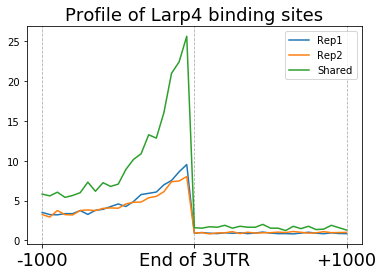

In [13]:
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), 0.5*norm_profile[0:num_profile_points], label='Rep1')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), 0.5*norm_profile2[0:num_profile_points], label='Rep2')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), 0.5*norm_profile3[0:num_profile_points], label='Shared')

ax.set_title("Profile of Larp4 binding sites", size=18)

ax.legend()
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')